# Runs the file containing general functions used in this script
## By default this is a file called "methane_functions.r" in the working directory of this script
## Do NOT change the working directory at any point while using this script.

In [14]:
methaneFunctions<-paste(getwd(),"/methane_functions.r",sep="")
methaneFunctions
if (file.exists(methaneFunctions)){
    source(methaneFunctions)
} else {
    print("manually correct the location and/or name of methane_functions.r")
}

[1] "/home/pleocavee/Documents/github/SensorDataProcessing/rriv_methane/methane_functions.r"

# 0. Load packages used

In [57]:
# Package names
packages<-c("dplyr", "lubridate", "ggplot2", "ggpubr","tidyverse","mgcv")
packageHandler(packages)

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.8-42. For overview type 'help("mgcv-package")'.



# 1. Script specific functions

# code specifically for 2023-04-11 deployment
start-logging, interactive mode, no summary lines, measurement cycle/burst cycle not incremented

Only 2 and 6 gathered full data

Deployment positions at dock were CH00 1&2 side by side, then 4 on its own, and 5&6 together.
Gas samples were taken in groups of 3, spaced out following the same grouping.

So, to be more specific for calibration, P1 could be used for CH002, and P3 for CH006, rather than averaging the three and guessing if there were outliers

In [3]:
exDirectory<-"~/Desktop/data/Methane Calibration/field_test/20230411_deployment"

In [15]:
rriv<-paste(sep="",exDirectory,"/RRIV")
data<-concat_dirs(rriv, read_rriv_CSV, minFileSize=300)
data<-process_rriv_columns(data)
raw_data<-subset(data, type=="raw")

Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning message:
“One or more parsing issues, see `problems()` for details”
Warning mess

[1] "Dataframe generated, manually process column types if necessary"


In [16]:
#manual dictionary to link UUIDs to sensors
UUIDdict<- c(
    '57FF70068387575129270167' = 'CH001', # flooded
    '50FF6B068678545244122467' = 'CH001', # new board, old board flooded
    '57FF6C068387575136470767' = 'CH002',
    '50FF6F068678545226521667' = 'CH003',
    '50FF6C068678545210222467' = 'CH004',
    '57FF6E068387575145101167' = 'CH005',
    '57FF74068387575109431367' = 'CH006'
)

processed_data<-createSensorColFromIDs(raw_data,idCol = "uuid",dict = UUIDdict)

In [17]:
unique(processed_data$Sensor)

[1] "CH001" "CH002" "CH004" "CH005" "CH006"

In [206]:
# processed_data$Sensor == "CH002" | processed_data$Sensor == "CH006"

In [18]:
outputDir<-paste(exDirectory,"_output/",sep="")
newDir(outputDir)

Output directory, ~/Desktop/data/Methane Calibration/field_test/20230411_deployment_output/, already exists


In [208]:
# variableDict<-getDict(raw_data)

# variableCount<-length(variableDict)
# variableKeys<-names(variableDict)

In [209]:
# rawPlots<-hourlyPlotsvTime(raw_data)

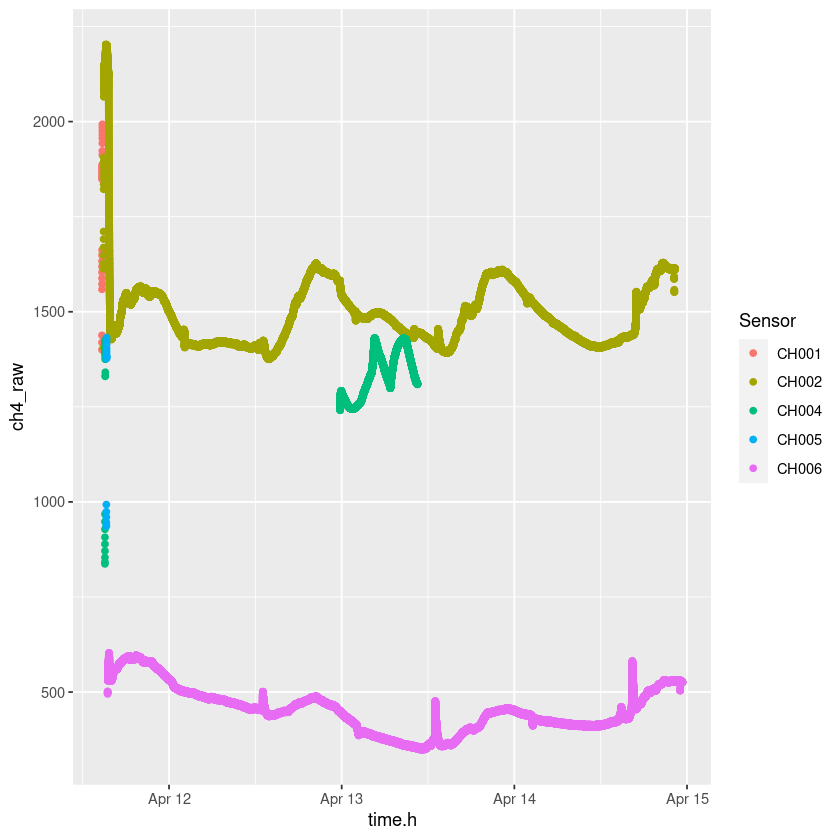

In [19]:
ggplot(data=processed_data, aes(x=time.h,y=ch4_raw,color=Sensor))+geom_point()

In [20]:
subset_data<-processed_data[processed_data$Sensor == "CH002" | processed_data$Sensor == "CH006" ,]

unique(subset_data$Sensor)

[1] "CH002" "CH006"

In [21]:
# clean co2 data, -1 are NA
subset_data$atlas_CO2_ppm[subset_data$atlas_CO2_ppm == -1]<-NA

In [22]:
subset_data<-calcAbsoluteHumidity(subset_data)

subset_data$ch4_V<-5/4096*subset_data$ch4_raw

[1] "2023-04-11 14:53:19 UTC" "2023-04-14 23:21:29 UTC"

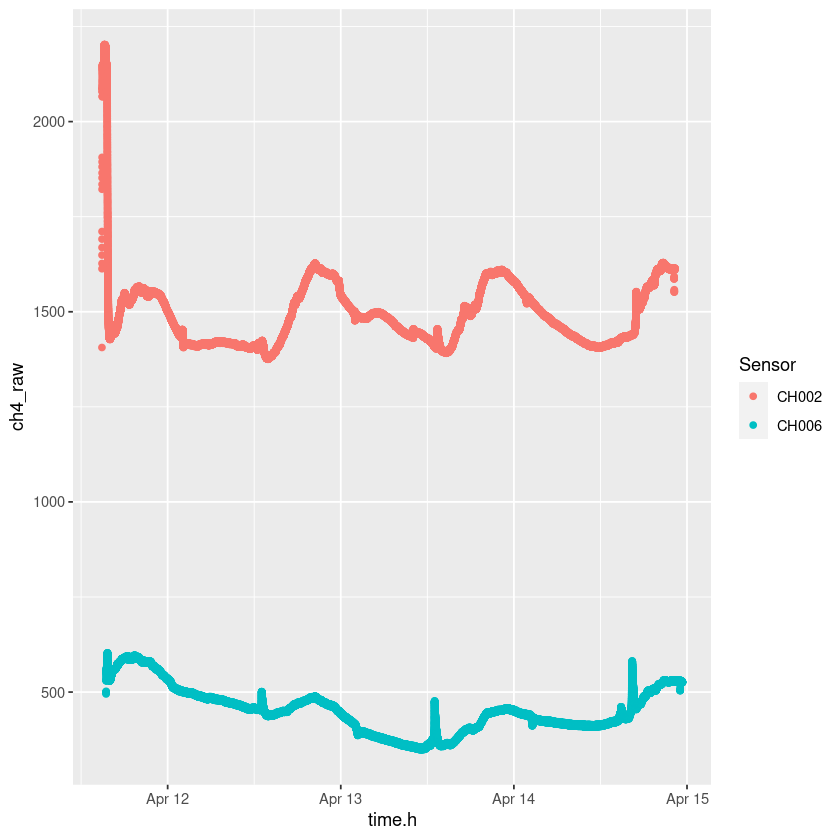

In [23]:
range(subset_data$time.h)
ggplot(subset_data,aes(x=time.h, y=ch4_raw, color=Sensor))+geom_point()

# GC data for 2023-04-11 deployment gas samples

In [24]:
gc<-paste(sep="",exDirectory,"/GC")
gc_data<-concat_dirs(gc, read.csv,filePattern = ".csv", minFileSize=0)

[1] "Dataframe generated, manually process column types if necessary"


In [215]:
# str(gc_data)

In [25]:
gc_data$Area<- as.numeric(gsub(",","",gc_data$Area))
str(gc_data)

'data.frame':	53 obs. of  16 variables:
 $ SAMPLEIDS    : chr  "N2_1" "N2_2" "N2_3" "N2_4" ...
 $ Data.        : int  1 2 3 12 13 14 3 4 6 7 ...
 $ Data.Filename: chr  "N2_1_4172023_001.gcd" "N2_2_4172023_002.gcd" "N2_3_4172023_003.gcd" "N2_4_4172023_012.gcd" ...
 $ Sample.Type  : chr  "Unknown" "Unknown" "Unknown" "Unknown" ...
 $ Level.       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Ret..Time    : num  2.68 2.83 2.81 2.81 2.82 ...
 $ Area         : num  3.71e+04 3.24e+03 1.27e+08 1.55e+04 3.98e+03 ...
 $ Height       : int  763 325 14060974 1725 432 5758217 300 10954469 1834 1566 ...
 $ Conc...ppm.  : num  5.66 4.93e-01 1.94e+04 2.36 6.07e-01 ...
 $ Std..Conc.   : chr  "-----" "-----" "-----" "-----" ...
 $ Area.        : num  11.68 4.51 95.92 9.27 3.12 ...
 $ Height.      : num  3.19 1.88 97.91 8 2.4 ...
 $ Accuracy...  : chr  "-----" "-----" "-----" "-----" ...
 $ Cal..Point   : chr  "-----" "-----" "-----" "-----" ...
 $ Known        : int  0 0 0 0 0 0 0 0 1 1 ...
 $ outlier      : chr  

In [26]:
gc_curve<-gc_data[!is.na(gc_data$Known) & gc_data$outlier != "y",]
gc_curve

,SAMPLEIDS,Data.,Data.Filename,Sample.Type,Level.,Ret..Time,Area,Height,Conc...ppm.,Std..Conc.,Area.,Height.,Accuracy...,Cal..Point,Known,outlier
,<chr>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<int>,<chr>
2,N2_2,2,N2_2_4172023_002.gcd,Unknown,0,2.825,3237,325,0.493,-----,4.513,1.881,-----,-----,0,
5,N2_5,13,N2_5_4172023_013.gcd,Unknown,0,2.817,3984,432,0.607,-----,3.116,2.402,-----,-----,0,
7,N2_7,3,N2_7_4172023_003.gcd,Unknown,0,2.819,2635,300,0.402,-----,4.907,2.256,-----,-----,0,
9,10CH4_1,6,10CH4_1_4172023_006.gcd,Unknown,0,2.814,16729,1834,2.549,-----,4.699,4.316,-----,-----,1,
10,10CH4_2,7,10CH4_2_4172023_007.gcd,Unknown,0,2.818,13976,1566,2.130,-----,4.242,3.989,-----,-----,1,
13,1CH4_1,4,1CH4_1_4172023_004.gcd,Unknown,0,2.815,45683,5098,6.962,-----,8.156,7.646,-----,-----,10,
14,1CH4_2,5,1CH4_2_4172023_005.gcd,Unknown,0,2.816,32062,3595,4.886,-----,7.996,7.651,-----,-----,10,
17,100CH4_3,1,100CH4_3_4172023_001.gcd,Unknown,0,2.813,499729,56083,76.160,-----,67.355,69.375,-----,-----,100,
18,100CH4_4,2,100CH4_4_4172023_002.gcd,Unknown,0,2.814,647636,57561,98.701,-----,64.865,65.373,-----,-----,100,


In [218]:
names(gc_curve)

[1] "SAMPLEIDS"     "Data."         "Data.Filename" "Sample.Type"  
 [5] "Level."        "Ret..Time"     "Area"          "Height"       
 [9] "Conc...ppm."   "Std..Conc."    "Area."         "Height."      
[13] "Accuracy..."   "Cal..Point"    "Known"         "outlier"

In [27]:
gc_curve_lm<-lm(formula=Known~Area, data=gc_curve)
summary(gc_curve_lm)


Call:
lm(formula = Known ~ Area, data = gc_curve)

Residuals:
    Min      1Q  Median      3Q     Max 
-123.42   17.36   21.01   23.01   43.30 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.432e+01  1.967e+01  -1.236    0.251    
Area         3.825e-04  2.311e-05  16.556 1.79e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 55.56 on 8 degrees of freedom
Multiple R-squared:  0.9716,	Adjusted R-squared:  0.9681 
F-statistic: 274.1 on 1 and 8 DF,  p-value: 1.789e-07


In [220]:
# intercept<-gc_curve_lm$coefficients[1]
# slope<-gc_curve_lm$coefficients[2]

# intercept
# slope

In [221]:
# gc_data$cal=slope*gc_data$Area+intercept
# gc_data

In [28]:
gc_data$cal<-predict(gc_curve_lm, gc_data)

In [29]:
gas_samples<-gc_data[is.na(gc_data$Known),]

In [30]:
head(gas_samples)

# reset index
rownames(gas_samples) <- NULL

gas_samples

,SAMPLEIDS,Data.,Data.Filename,Sample.Type,Level.,Ret..Time,Area,Height,Conc...ppm.,Std..Conc.,Area.,Height.,Accuracy...,Cal..Point,Known,outlier,cal
,<chr>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<int>,<chr>,<dbl>
21,P1_111308,15,P1_111308_4172023_015.gcd,Unknown,0,2.812,123670,13456,18.847,-----,22.446,22.054,-----,-----,NA,,22.98968
22,P2_111314,16,P2_111314_4172023_016.gcd,Unknown,0,2.813,460939,51552,70.248,-----,59.000,56.942,-----,-----,NA,,152.00521
23,P3_111319,17,P3_111319_4172023_017.gcd,Unknown,0,2.814,4164502,474097,634.677,-----,80.293,85.535,-----,-----,NA,y,1568.72941
24,P1_111701,18,P1_111701_4172023_018.gcd,Unknown,0,2.813,3331820,365608,507.775,-----,77.539,83.454,-----,-----,NA,,1250.20351
25,P2_111706,19,P2_111706_4172023_019.gcd,Unknown,0,2.814,3325283,365382,506.779,-----,77.893,83.867,-----,-----,NA,,1247.70291
26,P3_111712,20,P3_111712_4172023_020.gcd,Unknown,0,2.812,3300983,367808,503.075,-----,84.550,87.661,-----,-----,NA,,1238.40743


SAMPLEIDS,Data.,Data.Filename,Sample.Type,Level.,Ret..Time,Area,Height,Conc...ppm.,Std..Conc.,Area.,Height.,Accuracy...,Cal..Point,Known,outlier,cal
<chr>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<int>,<chr>,<dbl>
P1_111308,15,P1_111308_4172023_015.gcd,Unknown,0,2.812,123670,13456,18.847,-----,22.446,22.054,-----,-----,NA,,22.98968
P2_111314,16,P2_111314_4172023_016.gcd,Unknown,0,2.813,460939,51552,70.248,-----,59.000,56.942,-----,-----,NA,,152.00521
P3_111319,17,P3_111319_4172023_017.gcd,Unknown,0,2.814,4164502,474097,634.677,-----,80.293,85.535,-----,-----,NA,y,1568.72941
P1_111701,18,P1_111701_4172023_018.gcd,Unknown,0,2.813,3331820,365608,507.775,-----,77.539,83.454,-----,-----,NA,,1250.20351
P2_111706,19,P2_111706_4172023_019.gcd,Unknown,0,2.814,3325283,365382,506.779,-----,77.893,83.867,-----,-----,NA,,1247.70291
P3_111712,20,P3_111712_4172023_020.gcd,Unknown,0,2.812,3300983,367808,503.075,-----,84.550,87.661,-----,-----,NA,,1238.40743
P1_112125,21,P1_112125_4172023_021.gcd,Unknown,0,2.814,1813081,203844,276.317,-----,70.472,76.122,-----,-----,NA,y,669.24018
P2_112134,22,P2_112134_4172023_022.gcd,Unknown,0,2.816,379533,42797,57.842,-----,47.968,52.923,-----,-----,NA,,120.86497
P3_112139,23,P3_112139_4172023_023.gcd,Unknown,0,2.813,183554,20122,27.974,-----,34.731,37.483,-----,-----,NA,,45.89711


In [225]:
# gas_samples[c('SAMPLEIDS','Area','cal','cal2','datetime')]

In [31]:
# substr(gas_samples$SAMPLEIDS,4,5)
# substr(gas_samples$SAMPLEIDS,6,9)
# paste0("202304",substr(gas_samples$SAMPLEIDS,4,9))

# paste0("202304",substr(gas_samples$SAMPLEIDS,4,5)," ",substr(gas_samples$SAMPLEIDS,6,9))

# lubridate::as_datetime(paste0("202304",substr(gas_samples$SAMPLEIDS,4,5)," ",substr(gas_samples$SAMPLEIDS,6,9)),format="%Y%m%d %H%M")
gas_samples$dt_EDT<-lubridate::as_datetime(paste0("202304",substr(gas_samples$SAMPLEIDS,4,9)),format="%Y%m%d%H%M", tz="EDT")

gas_samples$dt_UTC<-lubridate::as_datetime(paste0("202304",substr(gas_samples$SAMPLEIDS,4,9)),format="%Y%m%d%H%M")
gas_samples$dt_UTC<-gas_samples$dt_UTC+4*60*60 # EDT -> UTC, 4hours

In [32]:
gas_samples$position<-substr(gas_samples$SAMPLEIDS,1,2)
gas_samples$position<-as.factor(gas_samples$position)

In [228]:
# gas_samples$utc<-lubridate::force_tz(gas_samples$datetime,"UTC")

# gas_samples$dt_EDT

# gas_samples$dt_UTC

# lubridate::force_tz(gas_samples$datetime,"UTC")
# gas_samples$datetime+4*60*60

In [229]:
# lubridate::force_tz(gas_samples$datetime,tzone = "EDT") # doesn't work properly, for utc, gmt, edt, est

In [33]:
# without what I consider to be outliers
gas_no_outliers<-gas_samples
gas_no_outliers$cal[gas_no_outliers$outlier=='y']<-NA
# gas_no_outliers

gas_NO_means_df<-data.frame()
i=1
while(i < nrow(gas_samples)){
    j=i+2
    temp<-summarise(.data=gas_no_outliers[i:j,],
                cal_mean = mean(cal, na.rm=TRUE),
                dt_UTC = mean(dt_UTC)
            )
    gas_NO_means_df<-rbind(gas_NO_means_df,temp)
    i=j+1
}
print(gas_NO_means_df)

     cal_mean              dt_UTC
1    87.49745 2023-04-11 17:13:40
2  1245.43795 2023-04-11 21:06:20
3    83.38104 2023-04-12 01:32:40
4  1593.32622 2023-04-12 13:22:00
5  2398.49680 2023-04-12 19:03:00
6  1542.57583 2023-04-13 02:50:00
7  2032.77090 2023-04-13 13:20:00
8  2622.18967 2023-04-13 17:58:20
9  1716.80871 2023-04-13 21:49:20
10 1269.63017 2023-04-14 02:22:00
11 1809.15555 2023-04-14 14:22:20


In [34]:
# with what I consider to be outliers
gas_means_df<-data.frame()
i=1
while(i < nrow(gas_samples)){
    j=i+2
    temp<-summarise(.data=gas_samples[i:j,],
                cal_mean = mean(cal),
                dt_UTC = mean(dt_UTC)
            )
    gas_means_df<-rbind(gas_means_df,temp)
    i=j+1
}
print(gas_means_df)

    cal_mean              dt_UTC
1   581.2414 2023-04-11 17:13:40
2  1245.4380 2023-04-11 21:06:20
3   278.6674 2023-04-12 01:32:40
4  1593.3262 2023-04-12 13:22:00
5  2398.4968 2023-04-12 19:03:00
6  1136.3781 2023-04-13 02:50:00
7  1689.5879 2023-04-13 13:20:00
8  2622.1897 2023-04-13 17:58:20
9  1293.5544 2023-04-13 21:49:20
10 1269.6302 2023-04-14 02:22:00
11 1809.1556 2023-04-14 14:22:20


In [232]:
## doesn't work, %/% 3 doesn't group properly
# gas_samples %>% mutate(three_index = 1:nrow(gas_samples) %/% 3) %>%
#             group_by(three_index) %>%
#             summarise(
#                 cal_mean = mean(cal),
#                 dt_UTC = mean(dt_UTC)
#             )

In [420]:
# gas_samples[c('SAMPLEIDS','Area','cal','dt_EDT','dt_UTC','position','outlier')]

In [234]:
# changes global options, so influences all further plots
# other method is to save specific dimensions and view outside of gui plot interface
options(repr.plot.width=15, repr.plot.height=8)

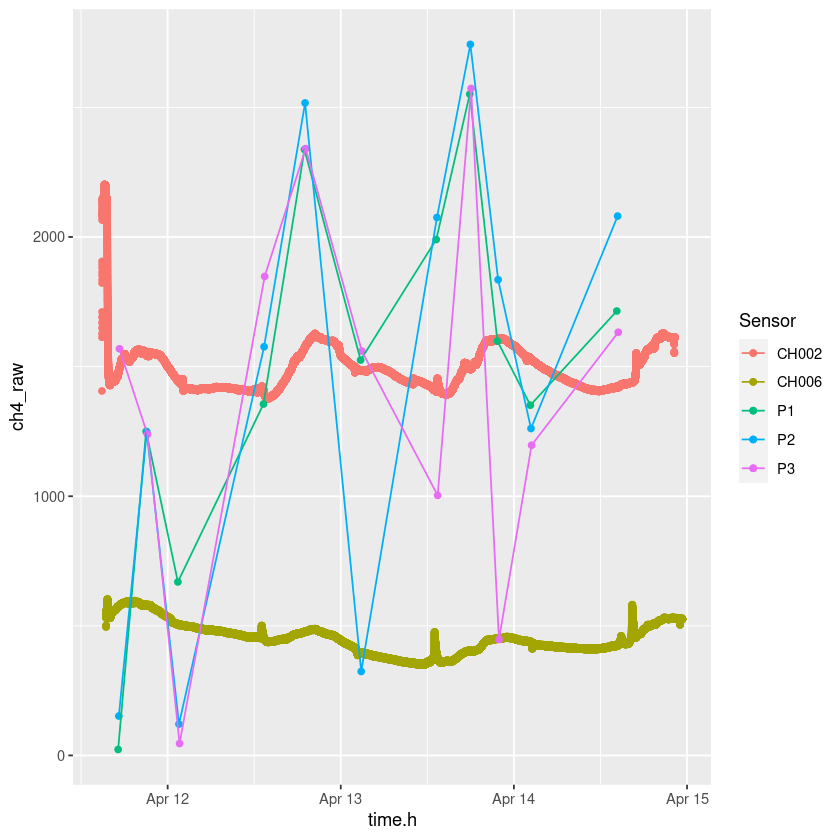

In [35]:
ggplot()+
    geom_point(data=subset_data, aes(x=time.h, y=ch4_raw, color=Sensor))+
    geom_point(data=gas_samples, aes(x=dt_UTC, y=cal, color=position))+
    geom_line(data=gas_samples, aes(x=dt_UTC, y=cal, color=position))

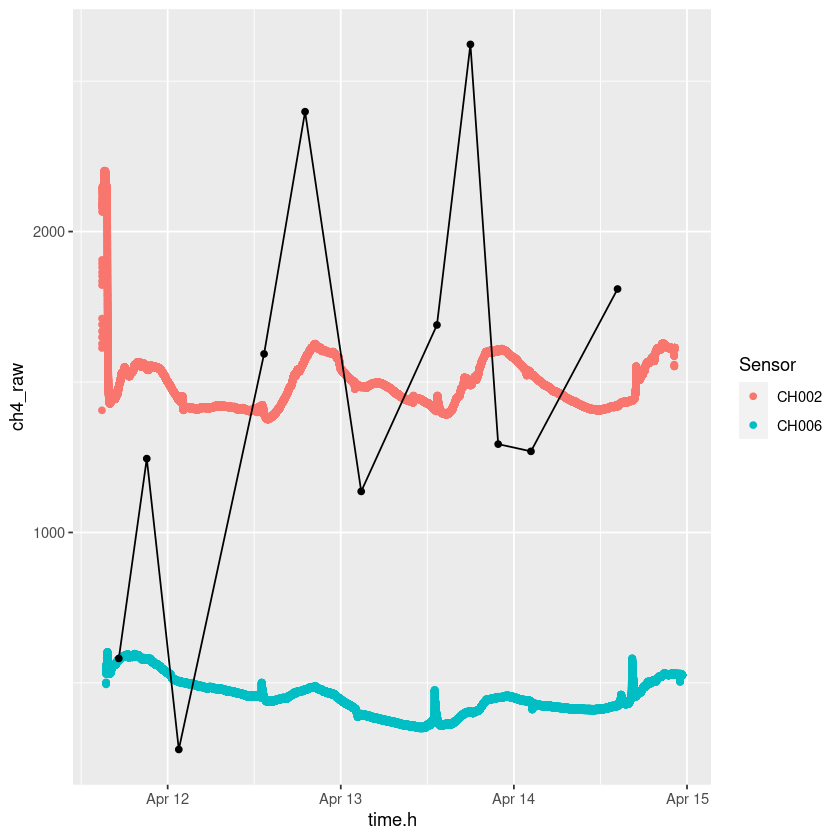

In [36]:
ggplot()+
    geom_point(data=subset_data, aes(x=time.h, y=ch4_raw, color=Sensor))+
    geom_point(data=gas_means_df, aes(x=dt_UTC, y=cal_mean))+
    geom_line(data=gas_means_df, aes(x=dt_UTC, y=cal_mean))

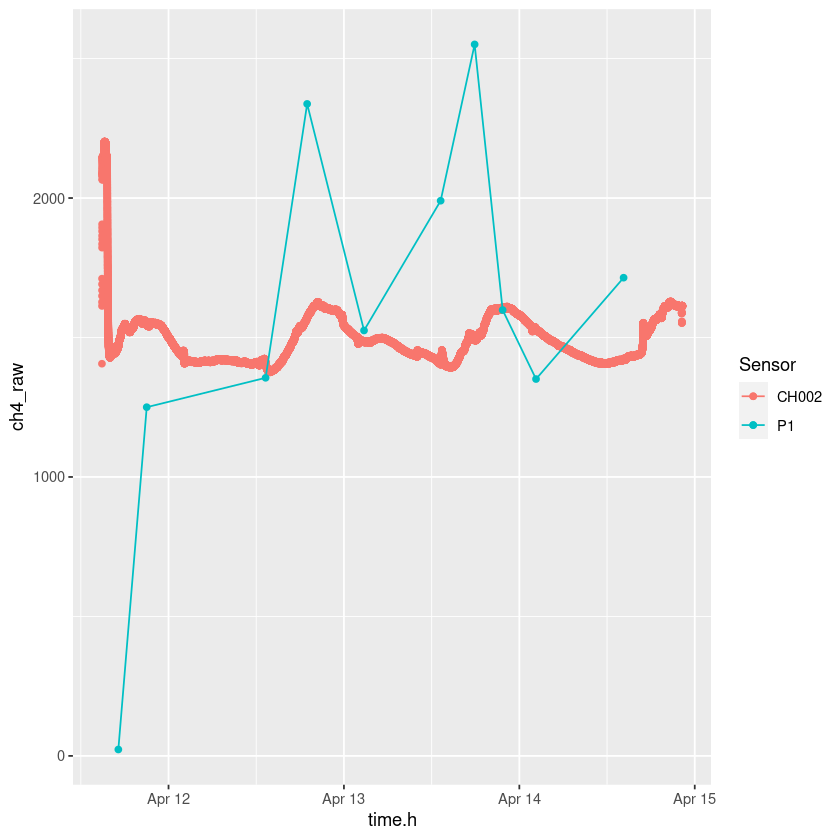

In [37]:
ggplot()+
    geom_point(data=subset_data[subset_data$Sensor=="CH002",], aes(x=time.h, y=ch4_raw, color=Sensor))+
    geom_point(data=gas_samples[gas_samples$position=="P1" & gas_samples$outlier != 'y',], aes(x=dt_UTC, y=cal, color=position))+
    geom_line(data=gas_samples[gas_samples$position=="P1" & gas_samples$outlier != 'y',], aes(x=dt_UTC, y=cal, color=position))

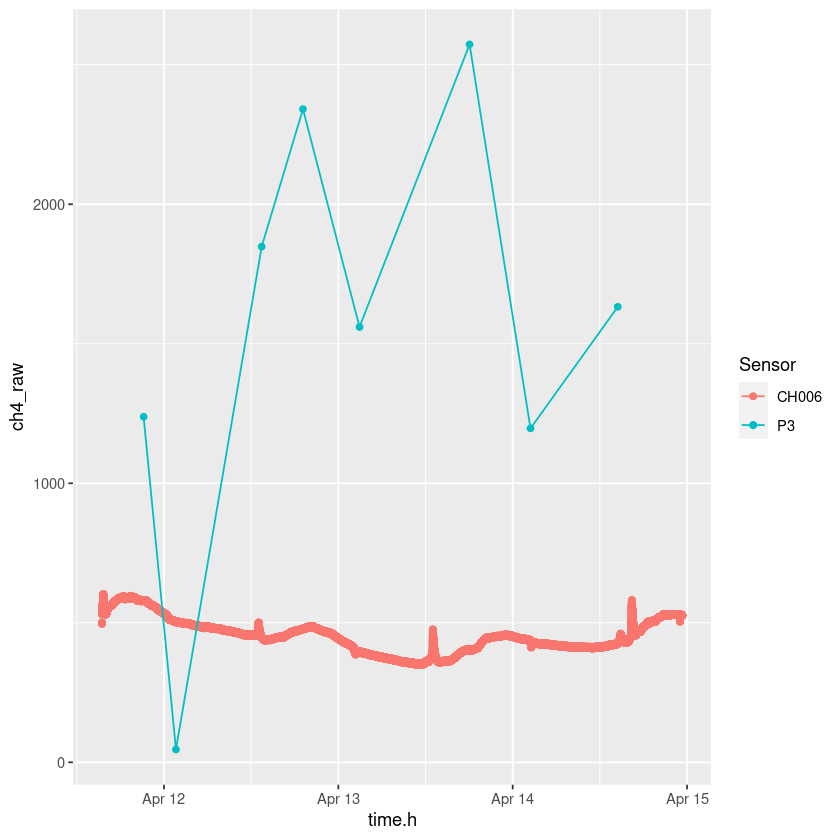

In [38]:
ggplot()+
    geom_point(data=subset_data[subset_data$Sensor=="CH006",], aes(x=time.h, y=ch4_raw, color=Sensor))+
    geom_point(data=gas_samples[gas_samples$position=="P3" & gas_samples$outlier != 'y',], aes(x=dt_UTC, y=cal, color=position))+
    geom_line(data=gas_samples[gas_samples$position=="P3" & gas_samples$outlier != 'y',], aes(x=dt_UTC, y=cal, color=position))

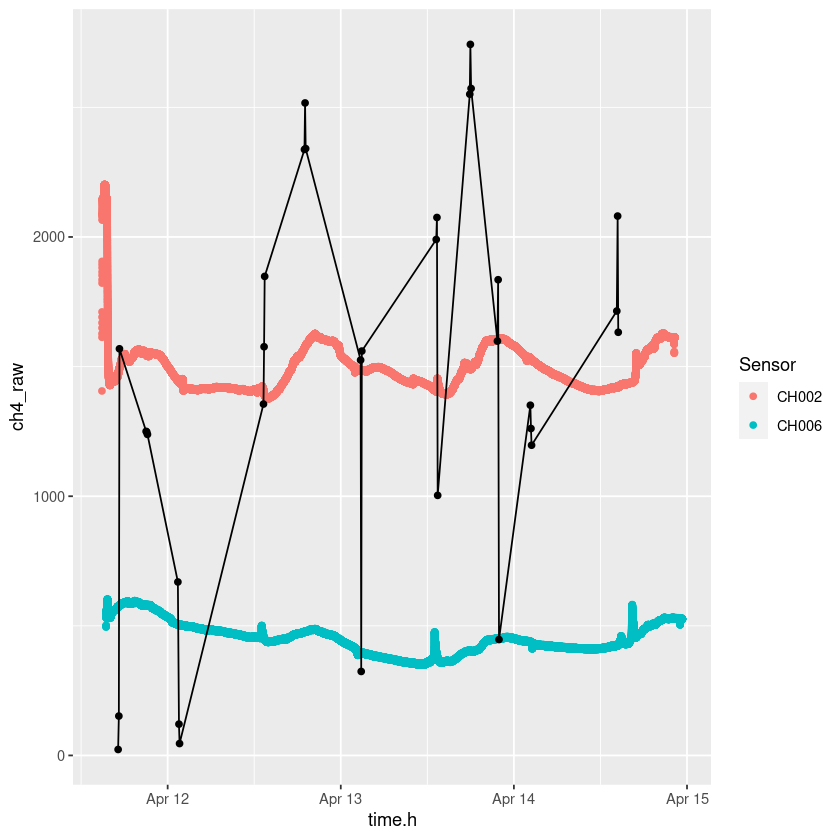

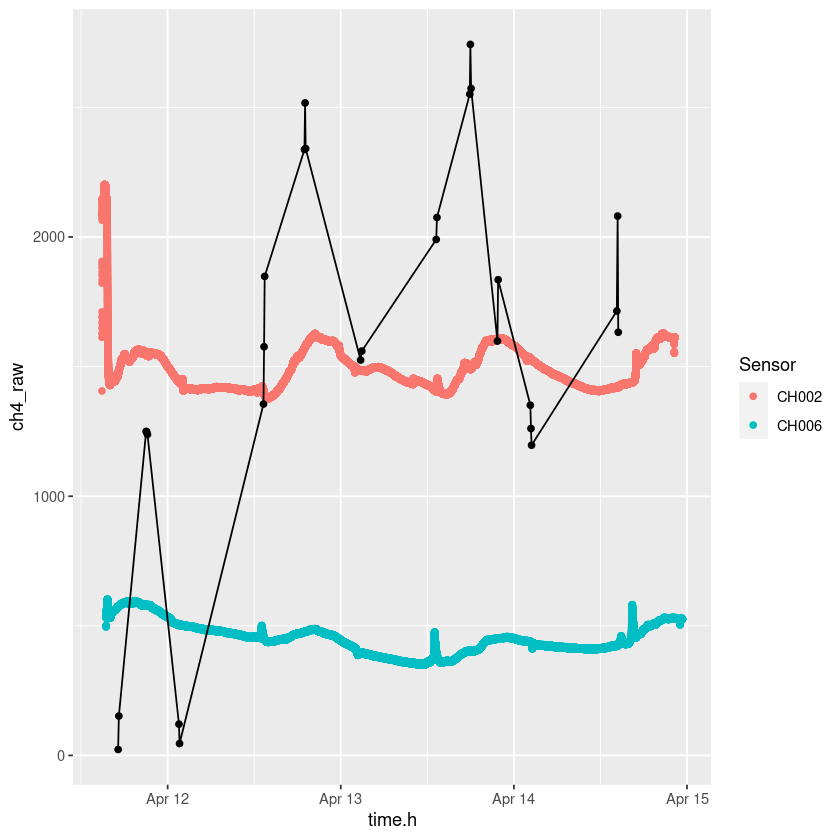

In [39]:
ggplot()+
    geom_point(data=subset_data, aes(x=time.h, y=ch4_raw, color=Sensor))+
    geom_point(data=gas_samples, aes(x=dt_UTC, y=cal))+
    geom_line(data=gas_samples, aes(x=dt_UTC, y=cal))

ggplot()+
    geom_point(data=subset_data, aes(x=time.h, y=ch4_raw, color=Sensor))+
    geom_point(data=gas_samples[gas_samples$outlier != "y",], aes(x=dt_UTC, y=cal))+
    geom_line(data=gas_samples[gas_samples$outlier != "y",], aes(x=dt_UTC, y=cal))

Warning message:
“Removed 21 rows containing missing values (geom_point).”
Warning message:
“Removed 21 rows containing missing values (geom_point).”
Warning message:
“Removed 21 rows containing missing values (geom_point).”
Warning message:
“Removed 21 rows containing missing values (geom_point).”


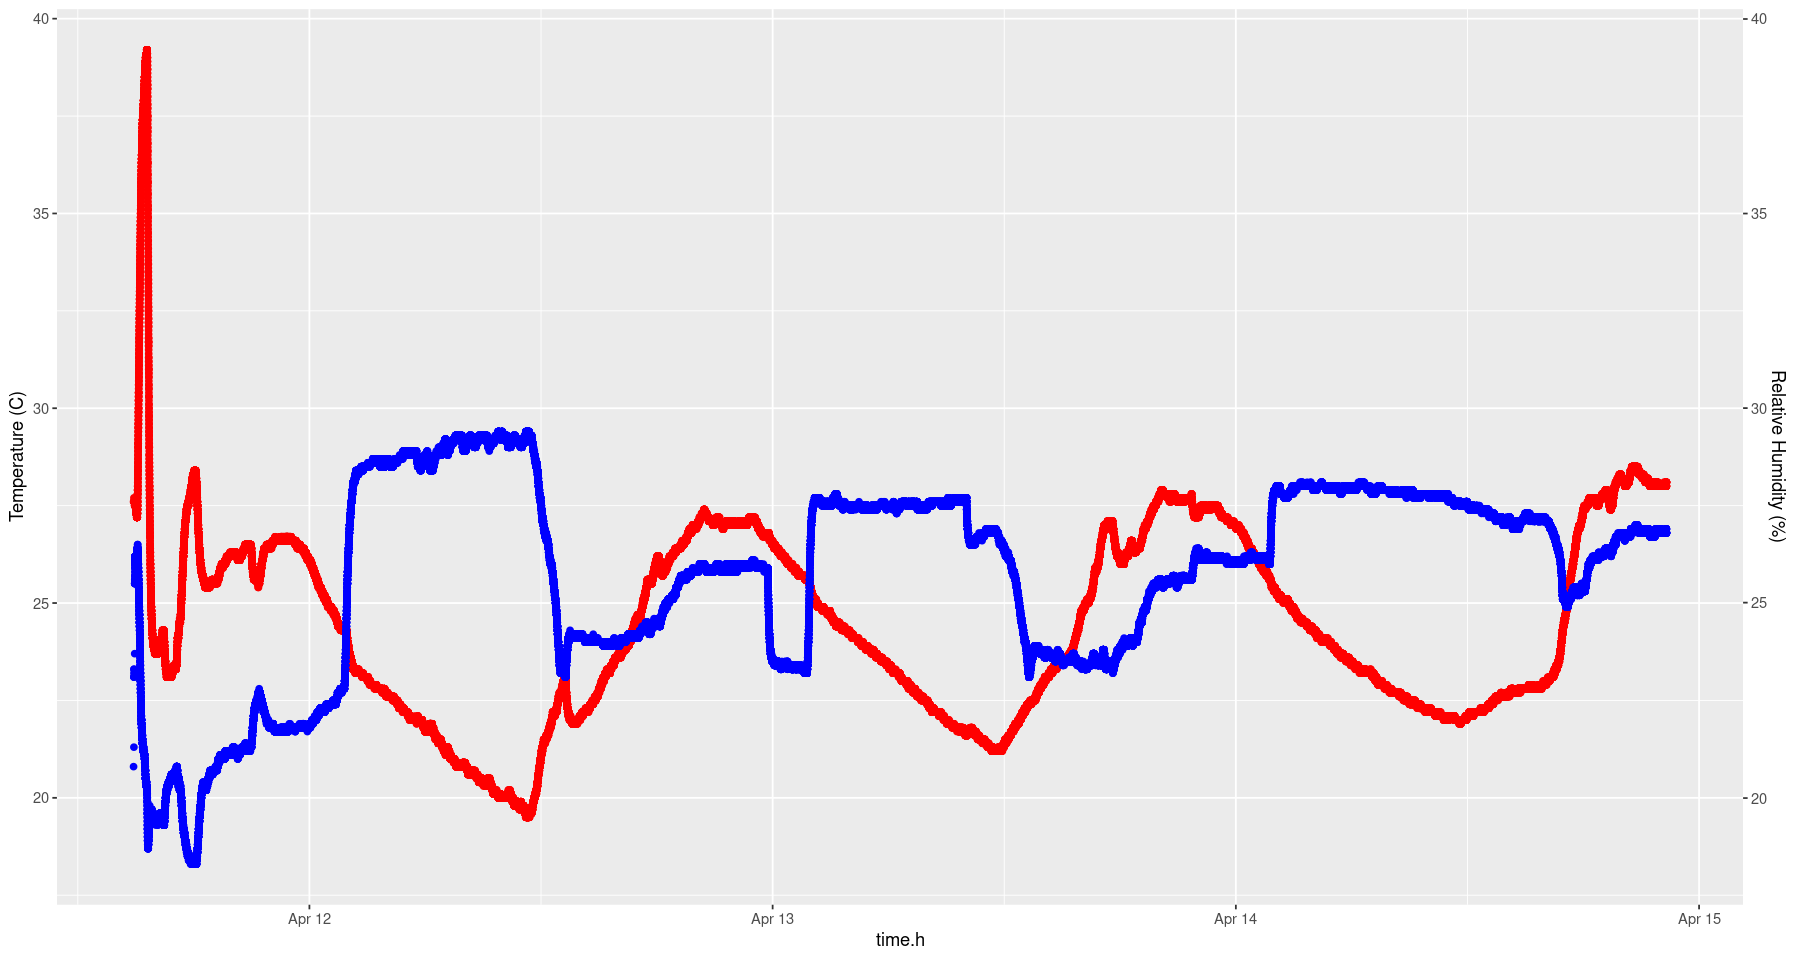

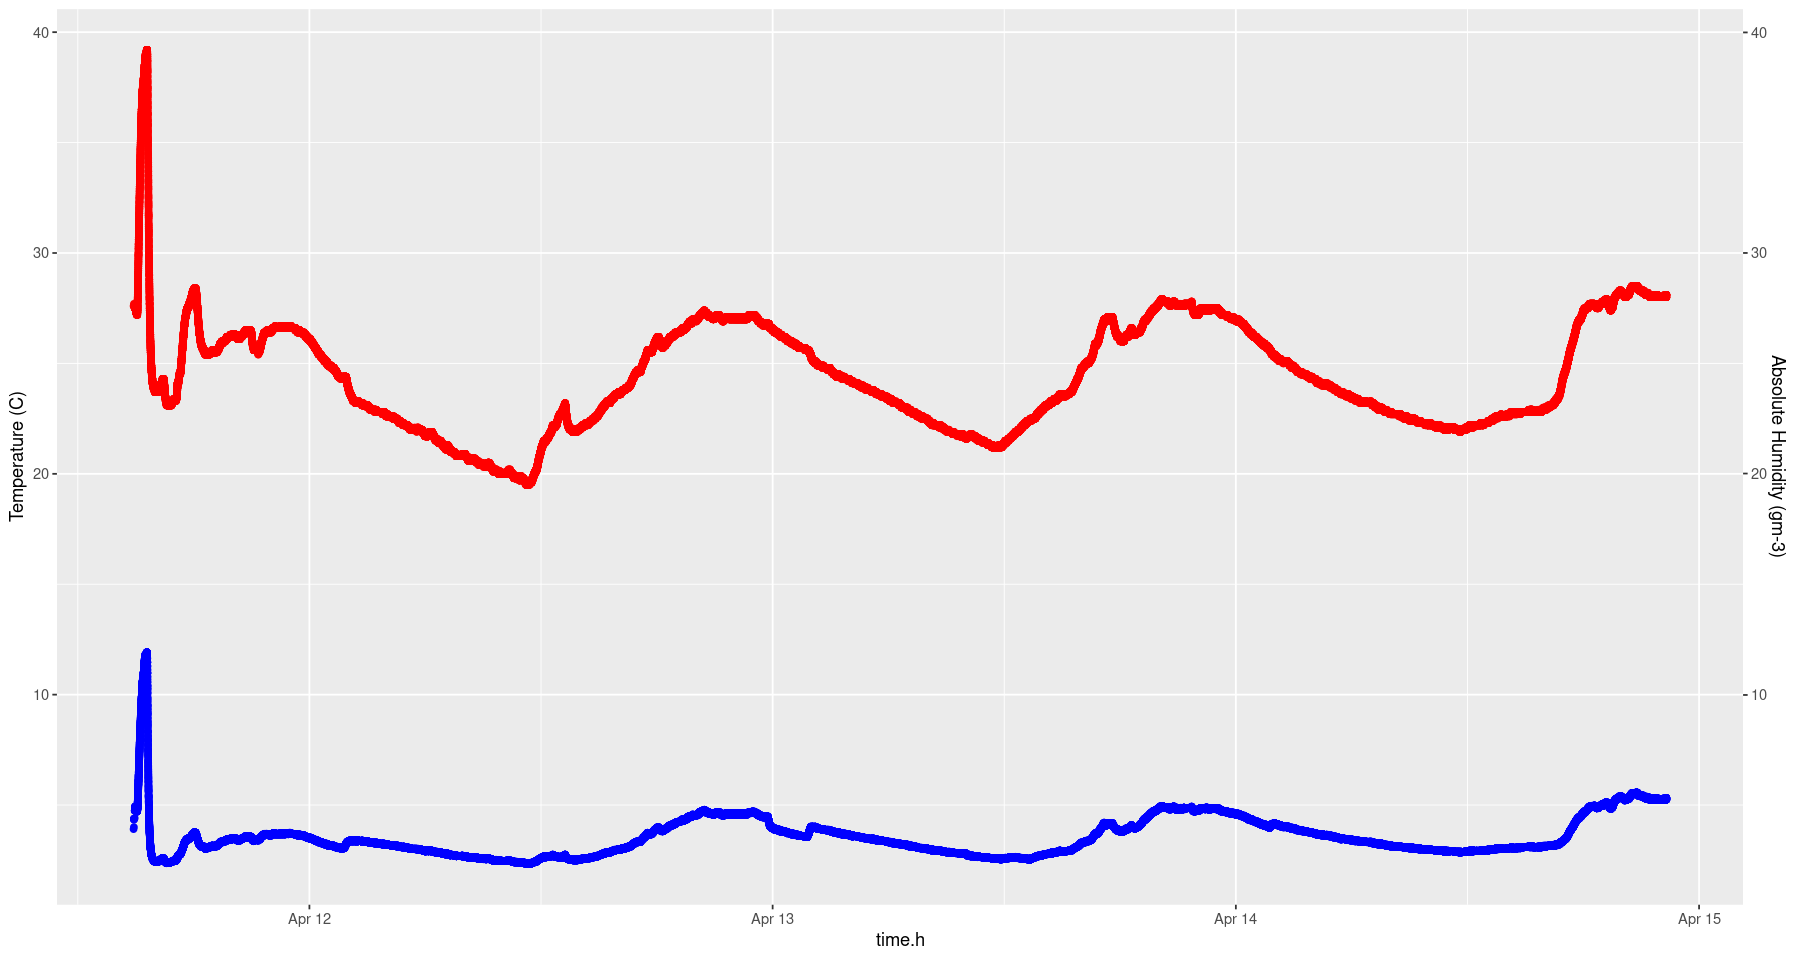

In [240]:
ggplot(data=subset_data[subset_data$Sensor=="CH002",], aes(x=time.h))+
    geom_point(aes(y=dht_C), color="red")+
    geom_point(aes(y=dht_RH), color="blue")+
    scale_y_continuous(name='Temperature (C)', sec.axis=sec_axis(~.*1,name="Relative Humidity (%)"))

ggplot(data=subset_data[subset_data$Sensor=="CH002",], aes(x=time.h))+
    geom_point(aes(y=dht_C), color="red")+
    geom_point(aes(y=aH_gm3), color="blue")+
    scale_y_continuous(name='Temperature (C)', sec.axis=sec_axis(~.*1,name="Absolute Humidity (gm-3)"))

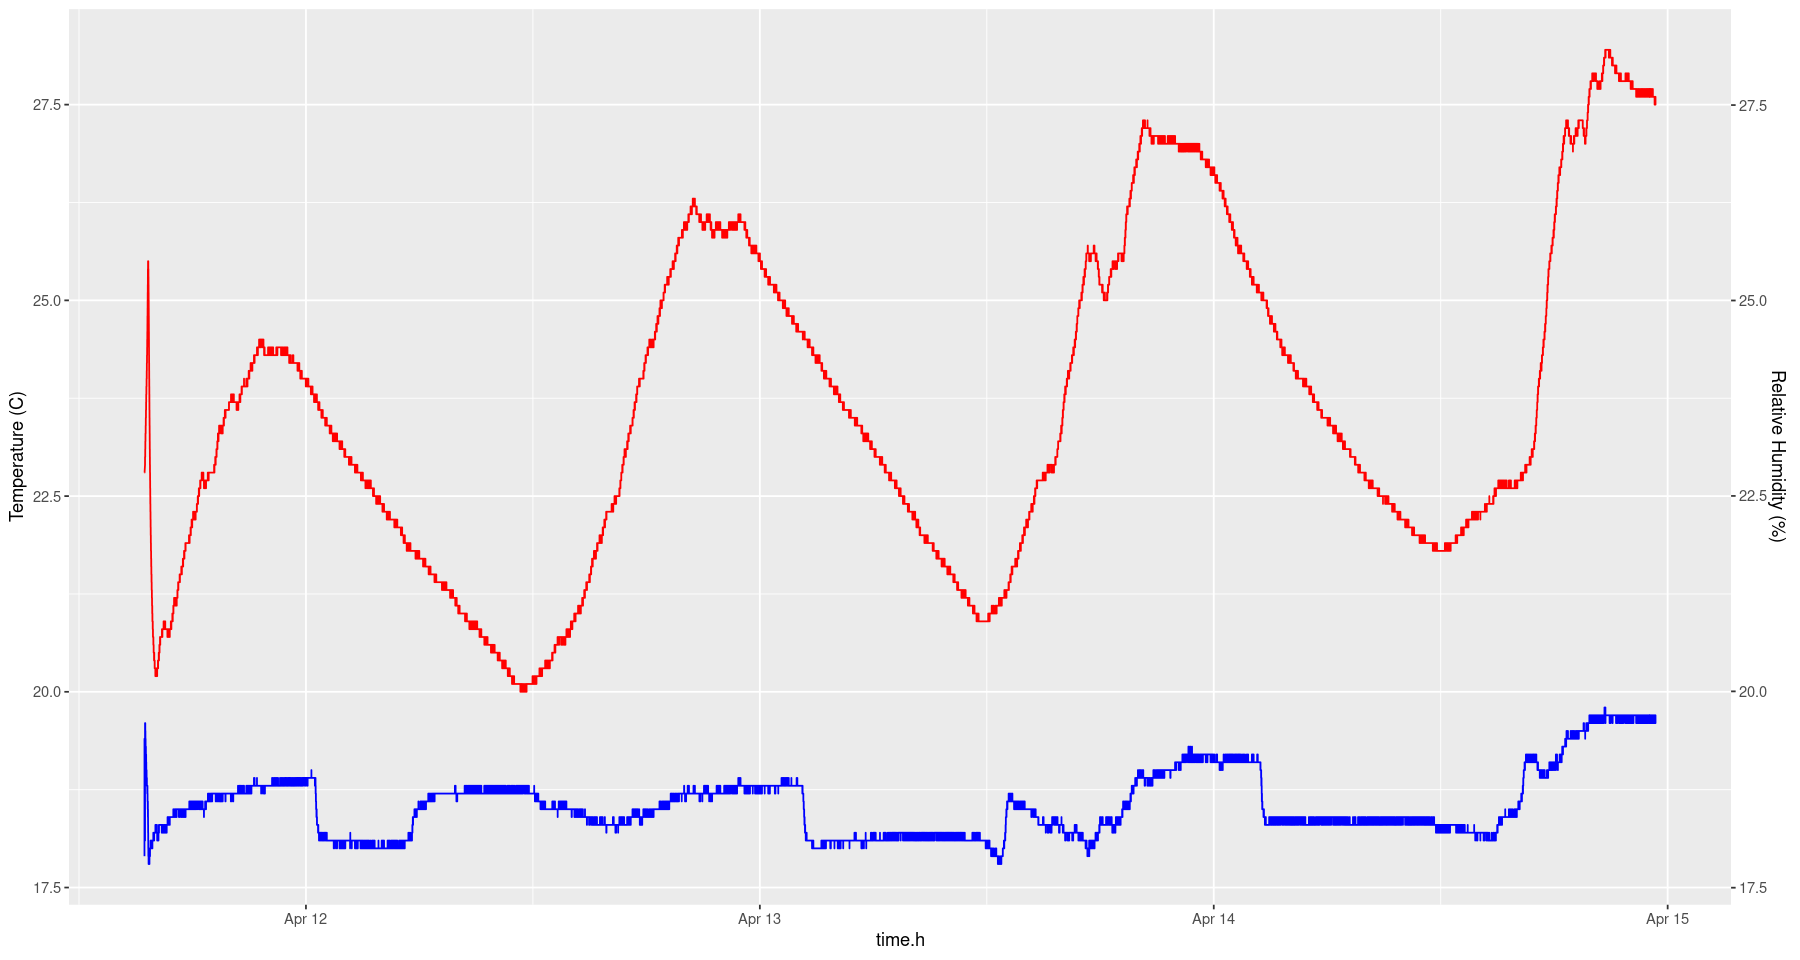

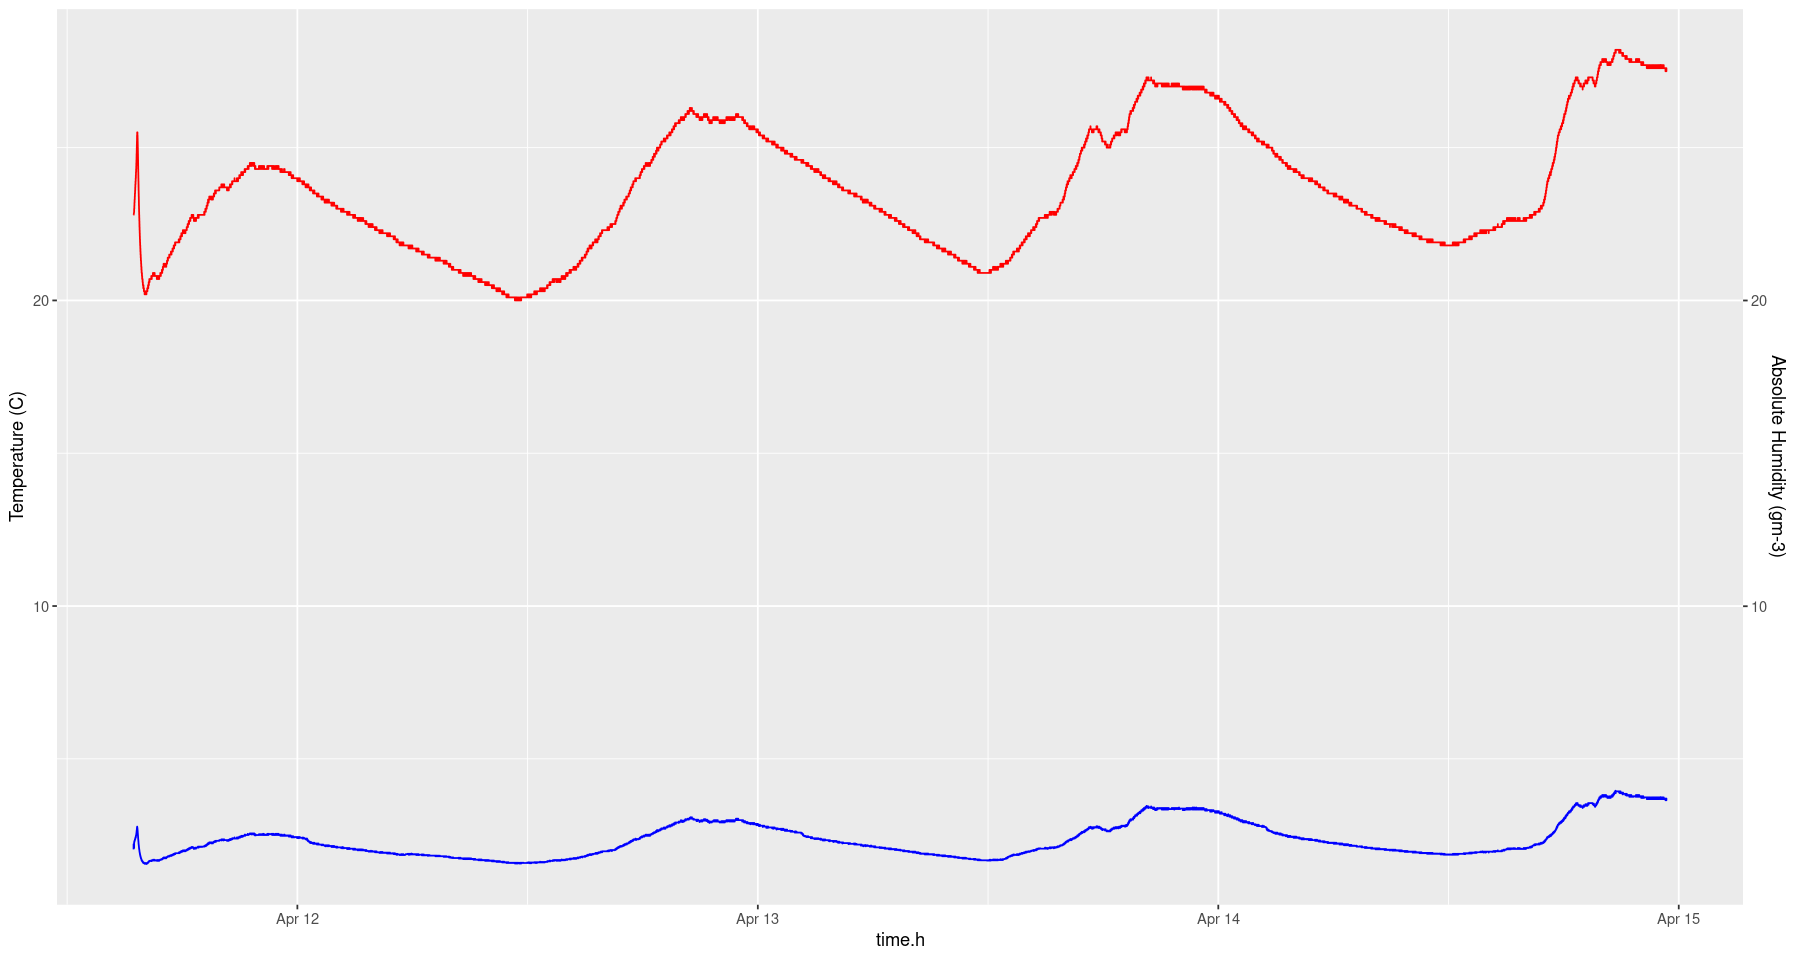

In [241]:
ggplot(data=subset_data[subset_data$Sensor=="CH006",], aes(x=time.h))+
    geom_line(aes(y=dht_C), color="red")+
    geom_line(aes(y=dht_RH), color="blue")+
    scale_y_continuous(name='Temperature (C)', sec.axis=sec_axis(~.*1,name="Relative Humidity (%)"))

ggplot(data=subset_data[subset_data$Sensor=="CH006",], aes(x=time.h))+
    geom_line(aes(y=dht_C), color="red")+
    geom_line(aes(y=aH_gm3), color="blue")+
    scale_y_continuous(name='Temperature (C)', sec.axis=sec_axis(~.*1,name="Absolute Humidity (gm-3)"))

# Align field samples and gas samples
1. average the 3 gas samples and use them for ch002 and ch006 (gas samples are at least 5 min apart)
2. use p1 for ch002, and p3 for ch006 (no replicates)
3. plot a curve for the gas samples and interpolate rriv data along it (not enough data for trends)

In [40]:
gas_means_df
gas_NO_means_df

cal_mean,dt_UTC
<dbl>,<dttm>
581.2414,2023-04-11 17:13:40
1245.4380,2023-04-11 21:06:20
278.6674,2023-04-12 01:32:40
1593.3262,2023-04-12 13:22:00
2398.4968,2023-04-12 19:03:00
1136.3781,2023-04-13 02:50:00
1689.5879,2023-04-13 13:20:00
2622.1897,2023-04-13 17:58:20
1293.5544,2023-04-13 21:49:20


cal_mean,dt_UTC
<dbl>,<dttm>
87.49745,2023-04-11 17:13:40
1245.43795,2023-04-11 21:06:20
83.38104,2023-04-12 01:32:40
1593.32622,2023-04-12 13:22:00
2398.49680,2023-04-12 19:03:00
1542.57583,2023-04-13 02:50:00
2032.77090,2023-04-13 13:20:00
2622.18967,2023-04-13 17:58:20
1716.80871,2023-04-13 21:49:20


In [41]:
nrow(gas_means_df)
names(subset_data)

[1] 11

[1] "type"             "site"             "logger"           "deployment"      
 [5] "deployed_at"      "uuid"             "time.s"           "time.h"          
 [9] "battery.V"        "measurementCycle" "burstCycle"       "dht_C"           
[13] "dht_RH"           "atlas_CO2_ppm"    "ch4rf_raw"        "ch4rf_cal"       
[17] "ch4_raw"          "ch4_cal"          "user_note"        "user_value"      
[21] "Sensor"           "ews_mbar"         "ews_kPa"          "aH_gm3"          
[25] "ch4_V"

In [42]:
# gas_means_df
# duplicate each row to use for each sensor
temp<-do.call("rbind",replicate(2, gas_means_df, simplify=FALSE))

temp<-temp[order(temp$dt_UTC),]

rownames(temp) <- NULL

cal_df_1<-temp

cal_df_1

cal_mean,dt_UTC
<dbl>,<dttm>
581.2414,2023-04-11 17:13:40
581.2414,2023-04-11 17:13:40
1245.4380,2023-04-11 21:06:20
1245.4380,2023-04-11 21:06:20
278.6674,2023-04-12 01:32:40
278.6674,2023-04-12 01:32:40
1593.3262,2023-04-12 13:22:00
1593.3262,2023-04-12 13:22:00
2398.4968,2023-04-12 19:03:00


In [43]:
# gas_means_df
# duplicate each row to use for each sensor
temp<-do.call("rbind",replicate(2, gas_NO_means_df, simplify=FALSE))

temp<-temp[order(temp$dt_UTC),]

rownames(temp) <- NULL

cal_df_1_NO<-temp

cal_df_1_NO

cal_mean,dt_UTC
<dbl>,<dttm>
87.49745,2023-04-11 17:13:40
87.49745,2023-04-11 17:13:40
1245.43795,2023-04-11 21:06:20
1245.43795,2023-04-11 21:06:20
83.38104,2023-04-12 01:32:40
83.38104,2023-04-12 01:32:40
1593.32622,2023-04-12 13:22:00
1593.32622,2023-04-12 13:22:00
2398.49680,2023-04-12 19:03:00


In [44]:
# determine amount of values to average
window<-60 #seconds

cal_df_2<-data.frame()
for(i in 1:nrow(gas_means_df)){
    time<-round(gas_means_df[i,2], units="hour")
    start = time - window/2
    end = time + window/2

    df_temp<-subset_data[subset_data$time.h >=start & subset_data$time.h <= end,]
    group_by(.data = df_temp, Sensor) %>%
    summarize(.groups="drop",
                      battery_V_mean<-mean(battery.V, na.rm=TRUE),
                      C_mean<-mean(dht_C, na.rm=TRUE),
                      RH_mean<-mean(dht_RH, na.rm=TRUE),
                      ch4_mean<-mean(ch4_raw, na.rm=TRUE),
                      Sensor=Sensor
                     ) -> s_temp
    s_temp<-unique(as.data.frame(s_temp))
    colnames(s_temp)<-c('Sensor','battery.V','dht_C','dht_RH','ch4_raw')
    cal_df_2<-rbind(cal_df_2,s_temp)
}
rownames(cal_df_2)<-NULL

print(cal_df_2)

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` inste

   Sensor battery.V    dht_C   dht_RH   ch4_raw
1   CH002  1342.800 23.30667 20.50667 1459.6333
2   CH006  1127.105 21.08947 18.40000  570.9474
3   CH002  1352.267 26.31000 21.36667 1554.6667
4   CH006  1116.263 24.06842 18.76316  579.9474
5   CH002  1302.333 23.92333 26.03000 1450.5000
6   CH006  1059.450 23.10000 18.07500  501.2000
7   CH002  1329.367 22.70000 23.29333 1402.7667
8   CH006  1078.316 20.40000 18.50000  467.1053
9   CH002  1368.267 26.37667 25.34667 1572.7333
10  CH006  1099.400 25.20000 18.51500  476.9500
11  CH002  1306.700 24.70000 27.60000 1484.7333
12  CH006  1020.200 24.28500 18.00000  393.5000
13  CH002  1323.833 22.20000 24.20000 1409.1000
14  CH006  1072.150 21.22000 18.29000  462.9500
15  CH002  1362.133 26.09000 23.79667 1490.9667
16  CH006  1090.650 25.20000 18.36000  403.4500
17  CH002  1366.467 27.20000 26.30000 1604.5667
18  CH006  1082.750 27.00000 19.03500  451.4500
19  CH002  1322.833 25.35333 27.85333 1536.4333
20  CH006  1035.737 25.30000 19.10000  4

In [45]:
cal_df<-cbind(cal_df_1,cal_df_2)
cal_df

cal_df_NO<-cbind(cal_df_1_NO,cal_df_2)
cal_df_NO

cal_mean,dt_UTC,Sensor,battery.V,dht_C,dht_RH,ch4_raw
<dbl>,<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
581.2414,2023-04-11 17:13:40,CH002,1342.800,23.30667,20.50667,1459.6333
581.2414,2023-04-11 17:13:40,CH006,1127.105,21.08947,18.40000,570.9474
1245.4380,2023-04-11 21:06:20,CH002,1352.267,26.31000,21.36667,1554.6667
1245.4380,2023-04-11 21:06:20,CH006,1116.263,24.06842,18.76316,579.9474
278.6674,2023-04-12 01:32:40,CH002,1302.333,23.92333,26.03000,1450.5000
278.6674,2023-04-12 01:32:40,CH006,1059.450,23.10000,18.07500,501.2000
1593.3262,2023-04-12 13:22:00,CH002,1329.367,22.70000,23.29333,1402.7667
1593.3262,2023-04-12 13:22:00,CH006,1078.316,20.40000,18.50000,467.1053
2398.4968,2023-04-12 19:03:00,CH002,1368.267,26.37667,25.34667,1572.7333


cal_mean,dt_UTC,Sensor,battery.V,dht_C,dht_RH,ch4_raw
<dbl>,<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
87.49745,2023-04-11 17:13:40,CH002,1342.800,23.30667,20.50667,1459.6333
87.49745,2023-04-11 17:13:40,CH006,1127.105,21.08947,18.40000,570.9474
1245.43795,2023-04-11 21:06:20,CH002,1352.267,26.31000,21.36667,1554.6667
1245.43795,2023-04-11 21:06:20,CH006,1116.263,24.06842,18.76316,579.9474
83.38104,2023-04-12 01:32:40,CH002,1302.333,23.92333,26.03000,1450.5000
83.38104,2023-04-12 01:32:40,CH006,1059.450,23.10000,18.07500,501.2000
1593.32622,2023-04-12 13:22:00,CH002,1329.367,22.70000,23.29333,1402.7667
1593.32622,2023-04-12 13:22:00,CH006,1078.316,20.40000,18.50000,467.1053
2398.49680,2023-04-12 19:03:00,CH002,1368.267,26.37667,25.34667,1572.7333


In [46]:
# calculate absolute humidity column
cal_df_NO<-calcAbsoluteHumidity(cal_df_NO)

# convert time column to EDT
cal_df_NO$dt_EDT<-cal_df_NO$dt_UTC-4*60*60

# calculate v0 column
lmFile<-"~/Desktop/data/Methane Calibration/methane_calibration_v0_output/V0_lm_CH001-CH006.rds"
cal_df_NO<-calcV0(cal_df_NO, lmFile)
head(cal_df_NO)

# calculate sensor resistance Rs
cal_df_NO<-calcSensorResistance(cal_df_NO)
head(cal_df_NO)

[1] "CH002"

Call:
lm(formula = ch4_raw ~ dht_C * aH_gm3, data = subset)

Coefficients:
 (Intercept)         dht_C        aH_gm3  dht_C:aH_gm3  
     447.524        20.447       334.416        -8.043  

[1] "CH006"

Call:
lm(formula = ch4_raw ~ dht_C * aH_gm3, data = subset)

Coefficients:
 (Intercept)         dht_C        aH_gm3  dht_C:aH_gm3  
    406.3112        4.4175       46.6585       -0.8317  



,cal_mean,dt_UTC,Sensor,battery.V,dht_C,dht_RH,ch4_raw,ews_mbar,ews_kPa,aH_gm3,dt_EDT,v0
,<dbl>,<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<dbl>
1,87.49745,2023-04-11 17:13:40,CH002,1342.800,23.30667,20.50667,1459.6333,16.42994,1.642994,2.462559,2023-04-11 13:13:40,1285.9562
2,87.49745,2023-04-11 17:13:40,CH006,1127.105,21.08947,18.40000,570.9474,12.86647,1.286647,1.743384,2023-04-11 13:13:40,550.2375
3,1245.43795,2023-04-11 21:06:20,CH002,1352.267,26.31000,21.36667,1554.6667,22.73259,2.273259,3.514501,2023-04-11 17:06:20,1417.0518
4,1245.43795,2023-04-11 21:06:20,CH006,1116.263,24.06842,18.76316,579.9474,17.85272,1.785272,2.442033,2023-04-11 17:06:20,577.6895
5,83.38104,2023-04-12 01:32:40,CH002,1302.333,23.92333,26.03000,1450.5000,17.57319,1.757319,3.336399,2023-04-11 21:32:40,1410.4296
6,83.38104,2023-04-12 01:32:40,CH006,1059.450,23.10000,18.07500,501.2000,16.06255,1.606255,2.123495,2023-04-11 21:32:40,566.6360


,cal_mean,dt_UTC,Sensor,battery.V,dht_C,dht_RH,ch4_raw,ews_mbar,ews_kPa,aH_gm3,dt_EDT,v0,ch4_V,v0_V,Rs_ohm
,<dbl>,<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>
1,87.49745,2023-04-11 17:13:40,CH002,1342.800,23.30667,20.50667,1459.6333,16.42994,1.642994,2.462559,2023-04-11 13:13:40,1285.9562,1.7817790,1.5697708,0.8265615
2,87.49745,2023-04-11 17:13:40,CH006,1127.105,21.08947,18.40000,570.9474,12.86647,1.286647,1.743384,2023-04-11 13:13:40,550.2375,0.6969572,0.6716767,0.9580984
3,1245.43795,2023-04-11 21:06:20,CH002,1352.267,26.31000,21.36667,1554.6667,22.73259,2.273259,3.514501,2023-04-11 17:06:20,1417.0518,1.8977865,1.7297996,0.8646608
4,1245.43795,2023-04-11 21:06:20,CH006,1116.263,24.06842,18.76316,579.9474,17.85272,1.785272,2.442033,2023-04-11 17:06:20,577.6895,0.7079436,0.7051873,0.9954675
5,83.38104,2023-04-12 01:32:40,CH002,1302.333,23.92333,26.03000,1450.5000,17.57319,1.757319,3.336399,2023-04-11 21:32:40,1410.4296,1.7706299,1.7217158,0.9578663
6,83.38104,2023-04-12 01:32:40,CH006,1059.450,23.10000,18.07500,501.2000,16.06255,1.606255,2.123495,2023-04-11 21:32:40,566.6360,0.6118164,0.6916944,1.1515198


In [47]:
# calculate absolute humidity column
cal_df<-calcAbsoluteHumidity(cal_df)

# convert time column to EDT
cal_df$dt_EDT<-cal_df$dt_UTC-4*60*60 # 4 hours

# calculate v0 column
lmFile<-"~/Desktop/data/Methane Calibration/methane_calibration_v0_output/V0_lm_CH001-CH006.rds"
cal_df<-calcV0(cal_df, lmFile)
head(cal_df)

# calculate sensor resistance Rs
cal_df<-calcSensorResistance(cal_df)
head(cal_df)

[1] "CH002"

Call:
lm(formula = ch4_raw ~ dht_C * aH_gm3, data = subset)

Coefficients:
 (Intercept)         dht_C        aH_gm3  dht_C:aH_gm3  
     447.524        20.447       334.416        -8.043  

[1] "CH006"

Call:
lm(formula = ch4_raw ~ dht_C * aH_gm3, data = subset)

Coefficients:
 (Intercept)         dht_C        aH_gm3  dht_C:aH_gm3  
    406.3112        4.4175       46.6585       -0.8317  



,cal_mean,dt_UTC,Sensor,battery.V,dht_C,dht_RH,ch4_raw,ews_mbar,ews_kPa,aH_gm3,dt_EDT,v0
,<dbl>,<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<dbl>
1,581.2414,2023-04-11 17:13:40,CH002,1342.800,23.30667,20.50667,1459.6333,16.42994,1.642994,2.462559,2023-04-11 13:13:40,1285.9562
2,581.2414,2023-04-11 17:13:40,CH006,1127.105,21.08947,18.40000,570.9474,12.86647,1.286647,1.743384,2023-04-11 13:13:40,550.2375
3,1245.4380,2023-04-11 21:06:20,CH002,1352.267,26.31000,21.36667,1554.6667,22.73259,2.273259,3.514501,2023-04-11 17:06:20,1417.0518
4,1245.4380,2023-04-11 21:06:20,CH006,1116.263,24.06842,18.76316,579.9474,17.85272,1.785272,2.442033,2023-04-11 17:06:20,577.6895
5,278.6674,2023-04-12 01:32:40,CH002,1302.333,23.92333,26.03000,1450.5000,17.57319,1.757319,3.336399,2023-04-11 21:32:40,1410.4296
6,278.6674,2023-04-12 01:32:40,CH006,1059.450,23.10000,18.07500,501.2000,16.06255,1.606255,2.123495,2023-04-11 21:32:40,566.6360


,cal_mean,dt_UTC,Sensor,battery.V,dht_C,dht_RH,ch4_raw,ews_mbar,ews_kPa,aH_gm3,dt_EDT,v0,ch4_V,v0_V,Rs_ohm
,<dbl>,<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>
1,581.2414,2023-04-11 17:13:40,CH002,1342.800,23.30667,20.50667,1459.6333,16.42994,1.642994,2.462559,2023-04-11 13:13:40,1285.9562,1.7817790,1.5697708,0.8265615
2,581.2414,2023-04-11 17:13:40,CH006,1127.105,21.08947,18.40000,570.9474,12.86647,1.286647,1.743384,2023-04-11 13:13:40,550.2375,0.6969572,0.6716767,0.9580984
3,1245.4380,2023-04-11 21:06:20,CH002,1352.267,26.31000,21.36667,1554.6667,22.73259,2.273259,3.514501,2023-04-11 17:06:20,1417.0518,1.8977865,1.7297996,0.8646608
4,1245.4380,2023-04-11 21:06:20,CH006,1116.263,24.06842,18.76316,579.9474,17.85272,1.785272,2.442033,2023-04-11 17:06:20,577.6895,0.7079436,0.7051873,0.9954675
5,278.6674,2023-04-12 01:32:40,CH002,1302.333,23.92333,26.03000,1450.5000,17.57319,1.757319,3.336399,2023-04-11 21:32:40,1410.4296,1.7706299,1.7217158,0.9578663
6,278.6674,2023-04-12 01:32:40,CH006,1059.450,23.10000,18.07500,501.2000,16.06255,1.606255,2.123495,2023-04-11 21:32:40,566.6360,0.6118164,0.6916944,1.1515198


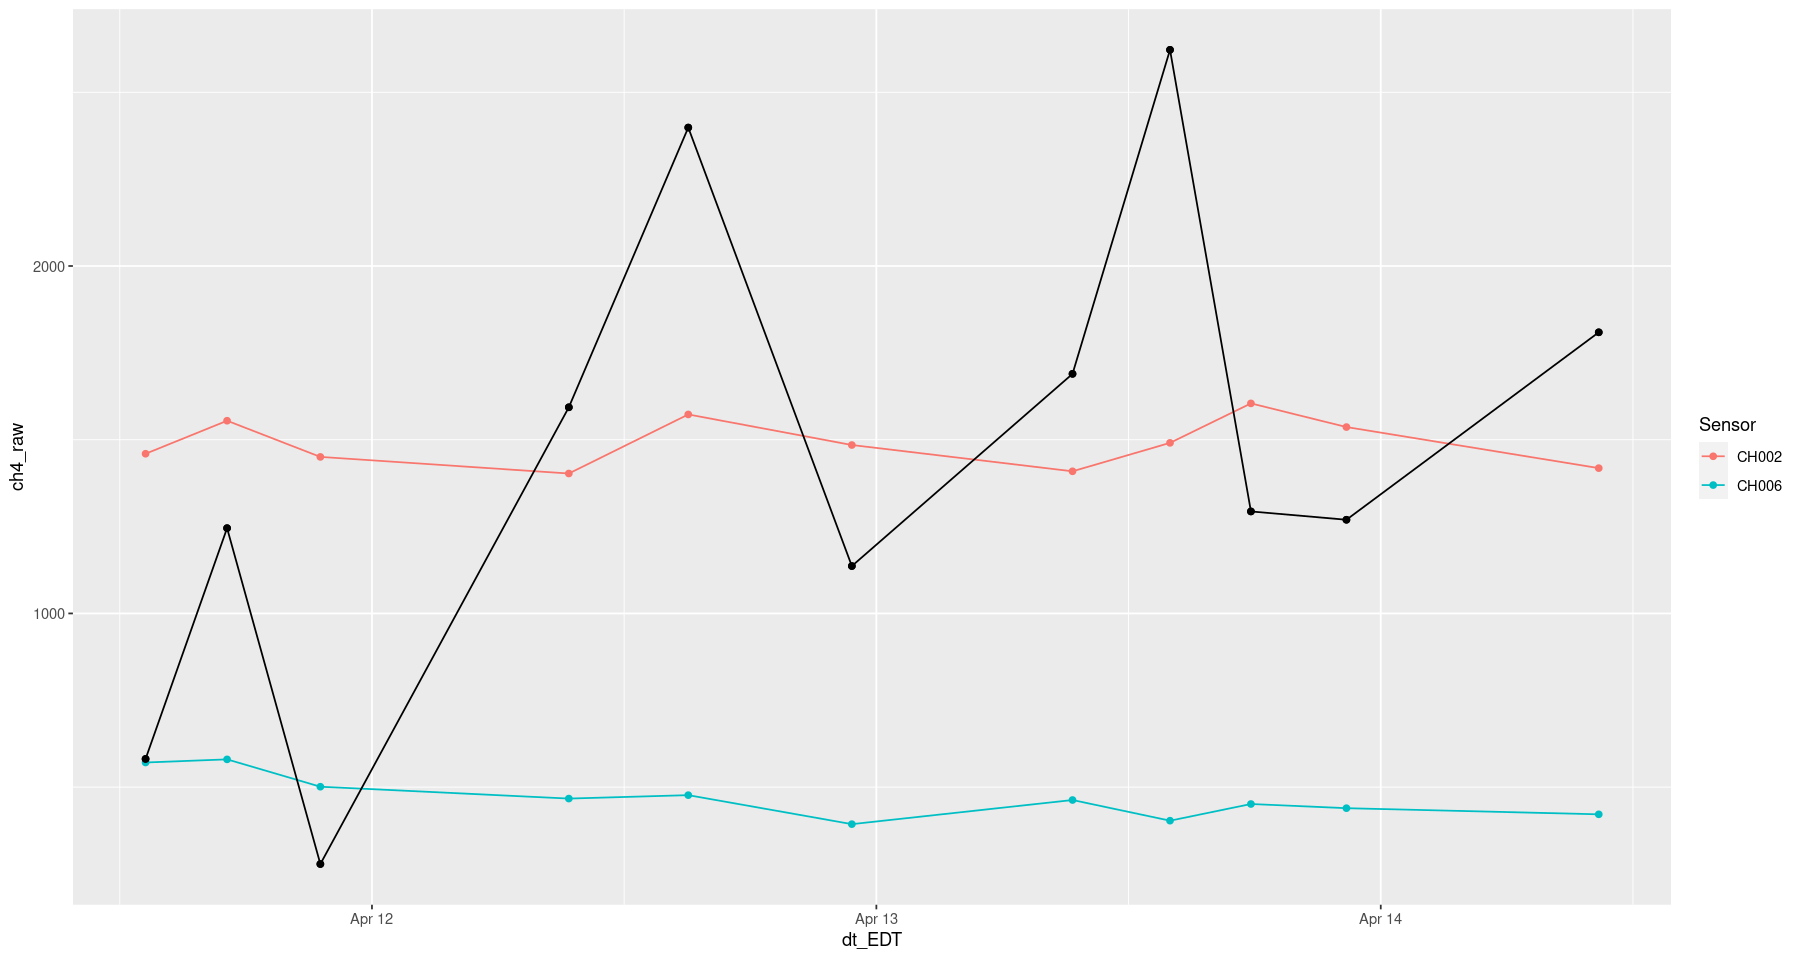

In [387]:
ggplot(cal_df,aes(x=dt_EDT))+
    geom_point(aes(y=ch4_raw,color=Sensor))+
    geom_line(aes(y=ch4_raw,color=Sensor))+
    geom_point(aes(y=cal_mean))+
    geom_line(aes(y=cal_mean))

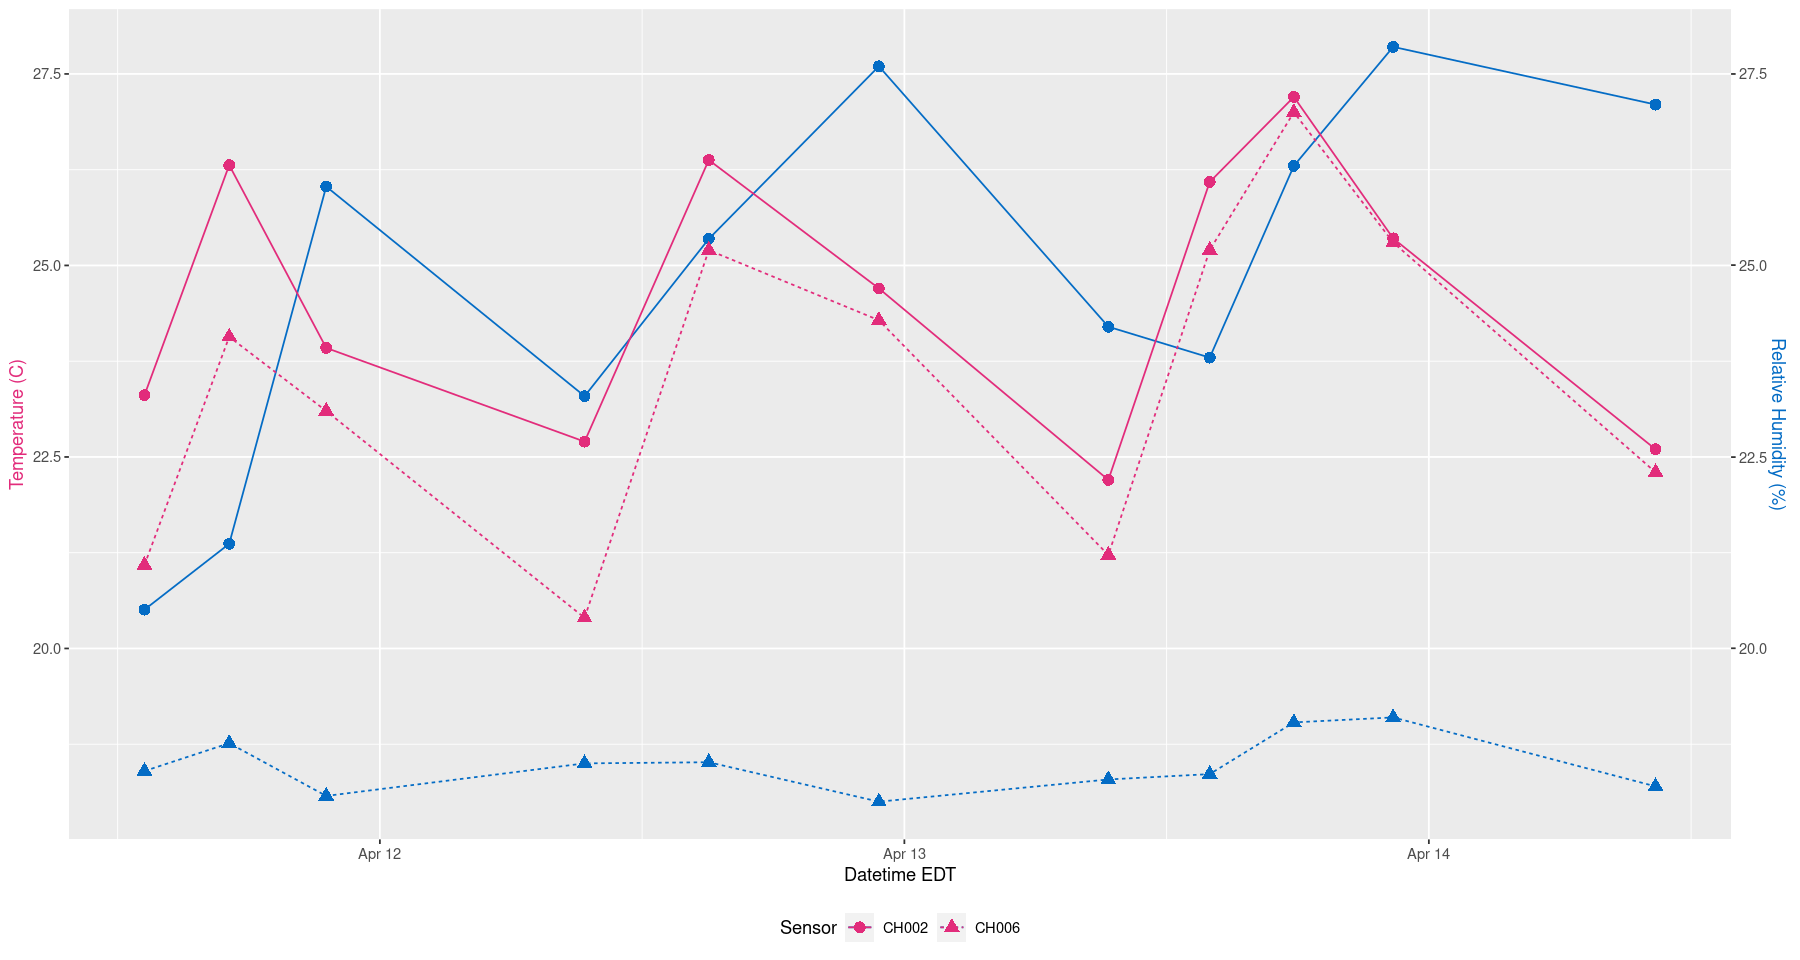

In [395]:
ggplot(cal_df,aes(x=dt_EDT, shape=Sensor, linetype=Sensor))+
    geom_point(aes(y=dht_RH), color='#046CC5', size=3)+
    geom_line(aes(y=dht_RH), color='#046CC5')+
    geom_point(aes(y=dht_C), color='#E22C7B', size=3)+
    geom_line(aes(y=dht_C), color='#E22C7B')+
    scale_y_continuous(name='Temperature (C)', sec.axis=sec_axis(~.*1,name="Relative Humidity (%)"))+
    labs(x="Datetime EDT")+
    theme(axis.title.y.left = element_text(color='#E22C7B'),
         axis.title.y.right = element_text(color='#046CC5'),
         legend.position='bottom')

# calibration linear models

In [48]:
# rename cal_mean to gc.ch4.ppm for equation
names(cal_df)[names(cal_df) == 'cal_mean'] <- 'gc.ch4.ppm'

names(cal_df_NO)[names(cal_df_NO) == 'cal_mean'] <- 'gc.ch4.ppm'

In [49]:
# include data used to generate V0
v0InputFile<-'~/Desktop/data/Methane Calibration/V0_tests_output/df_V0_input.csv'
v0Input<-read.csv(v0InputFile)

v0Input<-process_rriv_columns(v0Input)

v0Input<-createSensorColFromIDs(v0Input,idCol = "uuid",dict = UUIDdict)

v0Input<-v0Input[v0Input$Sensor=="CH002" |v0Input$Sensor=="CH006" ,]

cal_df$ch4_ppm <- cal_df$gc.ch4.ppm

cal_df_NO$ch4_ppm <- cal_df$gc.ch4.ppm

v0Input

,X,site,measurementCycle,type,deployment,deployed_at,uuid,time.s,time.h,battery.V,⋯,ch4_raw,ch4_cal,dht_C,dht_RH,ch4_ppm,dht_K,ews_mbar,ews_kPa,aH_gm3,Sensor
,<int>,<fct>,<int>,<fct>,<fct>,<int>,<fct>,<dbl>,<dttm>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
6,6,C2,41032,summary,floatWaterBin-57FF6C068387575136470767-1675179576,1675179576,57FF6C068387575136470767,1675459948,2023-02-03 21:32:27,1056.2,⋯,754.60,0,11.15,10.40,1.980557,284.30,4.078713,0.4078713,0.3232931,CH002
7,7,C2,42076,summary,floatWaterBin-57FF6C068387575136470767-1675179576,1675179576,57FF6C068387575136470767,1675355547,2023-02-02 16:32:27,1323.4,⋯,1436.86,0,31.72,15.11,1.995856,304.87,40.070170,4.0070170,4.3031629,CH002
8,8,C2,42092,summary,floatWaterBin-57FF6C068387575136470767-1675179576,1675179576,57FF6C068387575136470767,1675697548,2023-02-06 15:32:28,1273.4,⋯,1262.06,0,26.49,13.30,2.110608,299.64,23.173931,2.3173931,2.2287861,CH002
9,9,C2,42101,summary,floatWaterBin-57FF6C068387575136470767-1675179576,1675179576,57FF6C068387575136470767,1676064747,2023-02-10 21:32:27,1282.4,⋯,1315.86,0,27.80,14.40,1.993235,300.95,26.634086,2.6634086,2.7613584,CH002
10,10,C2,42116,summary,floatWaterBin-57FF6C068387575136470767-1675179576,1675179576,57FF6C068387575136470767,1675783948,2023-02-07 15:32:27,1302.6,⋯,1370.54,0,28.85,15.06,1.993682,302.00,29.747928,2.9747928,3.2143383,CH002
26,26,NC3,45022,summary,floatWaterBin-57FF74068387575109431367-1675179148,1675179148,57FF74068387575109431367,1675697549,2023-02-06 15:32:28,1163.8,⋯,851.94,0,23.50,93.97,2.110611,296.65,16.780689,1.6780689,11.5178517,CH006
27,27,NC3,45036,summary,floatWaterBin-57FF74068387575109431367-1675179148,1675179148,57FF74068387575109431367,1675355549,2023-02-02 16:32:28,1126.6,⋯,1030.70,0,28.79,99.51,1.995862,301.94,29.561255,2.9561255,21.1098798,CH006
28,28,NC3,45039,summary,floatWaterBin-57FF74068387575109431367-1675179148,1675179148,57FF74068387575109431367,1675459948,2023-02-03 21:32:27,975.6,⋯,512.70,0,7.00,99.90,1.980559,280.15,2.456766,0.2456766,1.8982592,CH006
29,29,NC3,45046,summary,floatWaterBin-57FF74068387575109431367-1675179148,1675179148,57FF74068387575109431367,1675783948,2023-02-07 15:32:27,1166.4,⋯,880.94,0,26.40,97.83,1.993682,299.55,22.952275,2.2952275,16.2422162,CH006


In [50]:
# convert time column to EDT
v0Input$dt_EDT<-v0Input$time.h-4*60*60 # 4 hours

# calculate v0 column
lmFile<-"~/Desktop/data/Methane Calibration/methane_calibration_v0_output/V0_lm_CH001-CH006.rds"
v0Input<-calcV0(v0Input, lmFile)
# head(v0Input)

# calculate sensor resistance Rs
v0Input<-calcSensorResistance(v0Input)
head(v0Input)

[1] "CH002"

Call:
lm(formula = ch4_raw ~ dht_C * aH_gm3, data = subset)

Coefficients:
 (Intercept)         dht_C        aH_gm3  dht_C:aH_gm3  
     447.524        20.447       334.416        -8.043  

[1] "CH006"

Call:
lm(formula = ch4_raw ~ dht_C * aH_gm3, data = subset)

Coefficients:
 (Intercept)         dht_C        aH_gm3  dht_C:aH_gm3  
    406.3112        4.4175       46.6585       -0.8317  



,X,site,measurementCycle,type,deployment,deployed_at,uuid,time.s,time.h,battery.V,⋯,dht_K,ews_mbar,ews_kPa,aH_gm3,Sensor,dt_EDT,v0,ch4_V,v0_V,Rs_ohm
,<int>,<fct>,<int>,<fct>,<fct>,<int>,<fct>,<dbl>,<dttm>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>
6,6,C2,41032,summary,floatWaterBin-57FF6C068387575136470767-1675179576,1675179576,57FF6C068387575136470767,1675459948,2023-02-03 21:32:27,1056.2,⋯,284.30,4.078713,0.4078713,0.3232931,CH002,2023-02-03 17:32:27,754.6294,0.9211426,0.9211785,1.0000478
7,7,C2,42076,summary,floatWaterBin-57FF6C068387575136470767-1675179576,1675179576,57FF6C068387575136470767,1675355547,2023-02-02 16:32:27,1323.4,⋯,304.87,40.070170,4.0070170,4.3031629,CH002,2023-02-02 12:32:27,1437.2644,1.7539795,1.7544732,1.0004336
8,8,C2,42092,summary,floatWaterBin-57FF6C068387575136470767-1675179576,1675179576,57FF6C068387575136470767,1675697548,2023-02-06 15:32:28,1273.4,⋯,299.64,23.173931,2.3173931,2.2287861,CH002,2023-02-06 11:32:28,1259.6253,1.5406006,1.5376285,0.9972141
9,9,C2,42101,summary,floatWaterBin-57FF6C068387575136470767-1675179576,1675179576,57FF6C068387575136470767,1676064747,2023-02-10 21:32:27,1282.4,⋯,300.95,26.634086,2.6634086,2.7613584,CH002,2023-02-10 17:32:27,1321.9415,1.6062744,1.6136981,1.0068241
10,10,C2,42116,summary,floatWaterBin-57FF6C068387575136470767-1675179576,1675179576,57FF6C068387575136470767,1675783948,2023-02-07 15:32:27,1302.6,⋯,302.00,29.747928,2.9747928,3.2143383,CH002,2023-02-07 11:32:27,1366.4593,1.6730225,1.6680412,0.9955320
26,26,NC3,45022,summary,floatWaterBin-57FF74068387575109431367-1675179148,1675179148,57FF74068387575109431367,1675697549,2023-02-06 15:32:28,1163.8,⋯,296.65,16.780689,1.6780689,11.5178517,CH006,2023-02-06 11:32:28,822.4033,1.0399658,1.0039103,0.9566202


In [51]:
names(v0Input)
names(cal_df_NO)

columns<-c('Sensor','dt_EDT','ch4_ppm','ch4_raw','Rs_ohm','dht_C','dht_RH','aH_gm3')

cal_df_NO_V0<-rbind(v0Input[columns] , cal_df_NO[columns])

cal_df_NO_V0

[1] "X"                "site"             "measurementCycle" "type"            
 [5] "deployment"       "deployed_at"      "uuid"             "time.s"          
 [9] "time.h"           "battery.V"        "ch4rf_raw"        "ch4rf_cal"       
[13] "ch4_raw"          "ch4_cal"          "dht_C"            "dht_RH"          
[17] "ch4_ppm"          "dht_K"            "ews_mbar"         "ews_kPa"         
[21] "aH_gm3"           "Sensor"           "dt_EDT"           "v0"              
[25] "ch4_V"            "v0_V"             "Rs_ohm"

[1] "gc.ch4.ppm" "dt_UTC"     "Sensor"     "battery.V"  "dht_C"     
 [6] "dht_RH"     "ch4_raw"    "ews_mbar"   "ews_kPa"    "aH_gm3"    
[11] "dt_EDT"     "v0"         "ch4_V"      "v0_V"       "Rs_ohm"    
[16] "ch4_ppm"

,Sensor,dt_EDT,ch4_ppm,ch4_raw,Rs_ohm,dht_C,dht_RH,aH_gm3
,<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,CH002,2023-02-03 17:32:27,1.980557,754.6000,1.0000478,11.15000,10.40000,0.3232931
7,CH002,2023-02-02 12:32:27,1.995856,1436.8600,1.0004336,31.72000,15.11000,4.3031629
8,CH002,2023-02-06 11:32:28,2.110608,1262.0600,0.9972141,26.49000,13.30000,2.2287861
9,CH002,2023-02-10 17:32:27,1.993235,1315.8600,1.0068241,27.80000,14.40000,2.7613584
10,CH002,2023-02-07 11:32:27,1.993682,1370.5400,0.9955320,28.85000,15.06000,3.2143383
26,CH006,2023-02-06 11:32:28,2.110611,851.9400,0.9566202,23.50000,93.97000,11.5178517
27,CH006,2023-02-02 12:32:28,1.995862,1030.7000,0.9771300,28.79000,99.51000,21.1098798
28,CH006,2023-02-03 17:32:27,1.980559,512.7000,1.0045771,7.00000,99.90000,1.8982592
29,CH006,2023-02-07 11:32:27,1.993682,880.9400,1.0633082,26.40000,97.83000,16.2422162


In [52]:
cal_df_NO_V0[cal_df_NO_V0$Sensor=='CH002',]

cal_df_NO_V0[cal_df_NO_V0$Sensor=='CH006',]

,Sensor,dt_EDT,ch4_ppm,ch4_raw,Rs_ohm,dht_C,dht_RH,aH_gm3
,<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,CH002,2023-02-03 17:32:27,1.980557,754.600,1.0000478,11.15000,10.40000,0.3232931
7,CH002,2023-02-02 12:32:27,1.995856,1436.860,1.0004336,31.72000,15.11000,4.3031629
8,CH002,2023-02-06 11:32:28,2.110608,1262.060,0.9972141,26.49000,13.30000,2.2287861
9,CH002,2023-02-10 17:32:27,1.993235,1315.860,1.0068241,27.80000,14.40000,2.7613584
10,CH002,2023-02-07 11:32:27,1.993682,1370.540,0.9955320,28.85000,15.06000,3.2143383
1,CH002,2023-04-11 13:13:40,581.241435,1459.633,0.8265615,23.30667,20.50667,2.4625586
3,CH002,2023-04-11 17:06:20,1245.437952,1554.667,0.8646608,26.31000,21.36667,3.5145014
5,CH002,2023-04-11 21:32:40,278.667421,1450.500,0.9578663,23.92333,26.03000,3.3363991
71,CH002,2023-04-12 09:22:00,1593.326223,1402.767,0.9026450,22.70000,23.29333,2.6226381


,Sensor,dt_EDT,ch4_ppm,ch4_raw,Rs_ohm,dht_C,dht_RH,aH_gm3
,<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
26,CH006,2023-02-06 11:32:28,2.110611,851.9400,0.9566202,23.50000,93.97000,11.517852
27,CH006,2023-02-02 12:32:28,1.995862,1030.7000,0.9771300,28.79000,99.51000,21.109880
28,CH006,2023-02-03 17:32:27,1.980559,512.7000,1.0045771,7.00000,99.90000,1.898259
29,CH006,2023-02-07 11:32:27,1.993682,880.9400,1.0633082,26.40000,97.83000,16.242216
30,CH006,2023-02-10 17:32:27,1.993236,633.5200,1.0038110,24.71000,33.04000,4.600098
2,CH006,2023-04-11 13:13:40,581.241435,570.9474,0.9580984,21.08947,18.40000,1.743384
4,CH006,2023-04-11 17:06:20,1245.437952,579.9474,0.9954675,24.06842,18.76316,2.442033
61,CH006,2023-04-11 21:32:40,278.667421,501.2000,1.1515198,23.10000,18.07500,2.123495
81,CH006,2023-04-12 09:22:00,1593.326223,467.1053,1.1916865,20.40000,18.50000,1.626977


In [53]:
head(subset_data)
unique(subset_data$Sensor)
names(subset_data)

calcV0()

,type,site,logger,deployment,deployed_at,uuid,time.s,time.h,battery.V,measurementCycle,⋯,ch4rf_cal,ch4_raw,ch4_cal,user_note,user_value,Sensor,ews_mbar,ews_kPa,aH_gm3,ch4_V
,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<dbl>,<dttm>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
38,raw,PWAD2,21011,fieldCal_CH002-57FF6C068387575136470767-1680553243,1680553243,57FF6C068387575136470767,1681224800,2023-04-11 14:53:19,1410,45756,⋯,0,1406,0,NA,NA,CH002,26.07647,2.607647,3.907719,1.716309
39,raw,PWAD2,21011,fieldCal_CH002-57FF6C068387575136470767-1680553243,1680553243,57FF6C068387575136470767,1681224829,2023-04-11 14:53:48,1461,45820,⋯,0,1613,0,NA,NA,CH002,NaN,NaN,NaN,1.968994
40,raw,PWAD2,21011,fieldCal_CH002-57FF6C068387575136470767-1680553243,1680553243,57FF6C068387575136470767,1681224831,2023-04-11 14:53:51,1387,45820,⋯,0,1627,0,NA,NA,CH002,NaN,NaN,NaN,1.986084
41,raw,PWAD2,21011,fieldCal_CH002-57FF6C068387575136470767-1680553243,1680553243,57FF6C068387575136470767,1681224834,2023-04-11 14:53:54,1393,45820,⋯,0,1649,0,NA,NA,CH002,NaN,NaN,NaN,2.012939
42,raw,PWAD2,21011,fieldCal_CH002-57FF6C068387575136470767-1680553243,1680553243,57FF6C068387575136470767,1681224837,2023-04-11 14:53:57,1396,45820,⋯,0,1669,0,NA,NA,CH002,NaN,NaN,NaN,2.037354
43,raw,PWAD2,21011,fieldCal_CH002-57FF6C068387575136470767-1680553243,1680553243,57FF6C068387575136470767,1681224840,2023-04-11 14:54:00,1400,45820,⋯,0,1691,0,NA,NA,CH002,NaN,NaN,NaN,2.064209


[1] "CH002" "CH006"

[1] "type"             "site"             "logger"           "deployment"      
 [5] "deployed_at"      "uuid"             "time.s"           "time.h"          
 [9] "battery.V"        "measurementCycle" "burstCycle"       "dht_C"           
[13] "dht_RH"           "atlas_CO2_ppm"    "ch4rf_raw"        "ch4rf_cal"       
[17] "ch4_raw"          "ch4_cal"          "user_note"        "user_value"      
[21] "Sensor"           "ews_mbar"         "ews_kPa"          "aH_gm3"          
[25] "ch4_V"

ERROR: Error in readRDS(v0lmFilePath): argument "v0lmFilePath" is missing, with no default


# CAL_DF_NoOutliers_V0 included

In [54]:
names(cal_df)

[1] "gc.ch4.ppm" "dt_UTC"     "Sensor"     "battery.V"  "dht_C"     
 [6] "dht_RH"     "ch4_raw"    "ews_mbar"   "ews_kPa"    "aH_gm3"    
[11] "dt_EDT"     "v0"         "ch4_V"      "v0_V"       "Rs_ohm"    
[16] "ch4_ppm"

In [61]:
cal_df

gc.ch4.ppm,dt_UTC,Sensor,battery.V,dht_C,dht_RH,ch4_raw,ews_mbar,ews_kPa,aH_gm3,dt_EDT,v0,ch4_V,v0_V,Rs_ohm,ch4_ppm
<dbl>,<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
581.2414,2023-04-11 17:13:40,CH002,1342.800,23.30667,20.50667,1459.6333,16.42994,1.642994,2.462559,2023-04-11 13:13:40,1285.9562,1.7817790,1.5697708,0.8265615,581.2414
581.2414,2023-04-11 17:13:40,CH006,1127.105,21.08947,18.40000,570.9474,12.86647,1.286647,1.743384,2023-04-11 13:13:40,550.2375,0.6969572,0.6716767,0.9580984,581.2414
1245.4380,2023-04-11 21:06:20,CH002,1352.267,26.31000,21.36667,1554.6667,22.73259,2.273259,3.514501,2023-04-11 17:06:20,1417.0518,1.8977865,1.7297996,0.8646608,1245.4380
1245.4380,2023-04-11 21:06:20,CH006,1116.263,24.06842,18.76316,579.9474,17.85272,1.785272,2.442033,2023-04-11 17:06:20,577.6895,0.7079436,0.7051873,0.9954675,1245.4380
278.6674,2023-04-12 01:32:40,CH002,1302.333,23.92333,26.03000,1450.5000,17.57319,1.757319,3.336399,2023-04-11 21:32:40,1410.4296,1.7706299,1.7217158,0.9578663,278.6674
278.6674,2023-04-12 01:32:40,CH006,1059.450,23.10000,18.07500,501.2000,16.06255,1.606255,2.123495,2023-04-11 21:32:40,566.6360,0.6118164,0.6916944,1.1515198,278.6674
1593.3262,2023-04-12 13:22:00,CH002,1329.367,22.70000,23.29333,1402.7667,15.37310,1.537310,2.622638,2023-04-12 09:22:00,1309.8733,1.7123617,1.5989664,0.9026450,1593.3262
1593.3262,2023-04-12 13:22:00,CH006,1078.316,20.40000,18.50000,467.1053,11.91447,1.191447,1.626977,2023-04-12 09:22:00,544.7352,0.5701969,0.6649600,1.1916865,1593.3262
2398.4968,2023-04-12 19:03:00,CH002,1368.267,26.37667,25.34667,1572.7333,22.89513,2.289513,4.198028,2023-04-12 15:03:00,1500.0980,1.9198405,1.8311743,0.9271273,2398.4968


In [60]:
# cal_df_NO_V0

# for each sensor
# TODO: preserve the lm's produced for each sensor for use with predict()
sensors<-unique(cal_df_NO_V0$Sensor)
lm_output<-vector('list',length(sensors))
names(lm_output)<-sensors
# str(lm_output)

for(sensor in sensors){
    temp<-cal_df[cal_df_NO_V0$Sensor == sensor,]
    print(sensor)
#     print(temp)
#     temp_lm<-lm(data=temp, formula=ch4_ppm~Rs_ohm*dht_C*dht_RH)
    temp_lm<-lm(data=temp, formula=ch4_ppm~ch4_raw*dht_C*dht_RH)
    lm_output[[sensor]]<-temp_lm
    print(summary( lm_output[[sensor]] ))
    
    temp_lm<-lm(data=temp, formula=ch4_ppm~ch4_raw+dht_C+dht_RH)
    print(summary(temp_lm))
    
#     temp_gam<-mgcv::gam(ch4_ppm~s(ch4_raw)+s(dht_C)+s(dht_RH),data=temp)
#     print(summary(temp_gam))
    
#     outFile<-paste0(outputDir, sensor,"_bastviken_lm.txt")
#     writeLines<-capture.output(summary( lm_output[[sensor]] ))
#     writeFile(writeLines, outFile)
}

# outFile<-paste0(outputDir,"bastviken_lm.rds")
# saveRDS(lm_output,outFile)

[1] "CH002"

Call:
lm(formula = ch4_ppm ~ ch4_raw * dht_C * dht_RH, data = temp)

Residuals:
        1         2         3         4         5        11        13        15 
 -130.909     3.091  -177.337   -21.112 -1160.818  -171.183   445.649   755.794 
       17        19        21 
 -263.646   521.203   199.270 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)
(Intercept)          -2.574e+05  3.475e+05  -0.741    0.513
ch4_raw               1.867e+02  2.633e+02   0.709    0.530
dht_C                 7.624e+03  1.268e+04   0.601    0.590
dht_RH                1.434e+04  1.907e+04   0.752    0.507
ch4_raw:dht_C        -5.665e+00  9.323e+00  -0.608    0.586
ch4_raw:dht_RH       -1.056e+01  1.425e+01  -0.741    0.512
dht_C:dht_RH         -4.286e+02  6.925e+02  -0.619    0.580
ch4_raw:dht_C:dht_RH  3.263e-01  5.038e-01   0.648    0.563

Residual standard error: 926.7 on 3 degrees of freedom
  (5 observations deleted due to missingness)
Multiple R-squared:  0.392

In [463]:
# v0Input[columns]
# cal_df_NO[columns]

In [461]:
# head(cal_df)

In [62]:
# for each sensor
# TODO: preserve the lm's produced for each sensor for use with predict()
sensors<-unique(cal_df$Sensor)
lm_output<-vector('list',length(sensors))
names(lm_output)<-sensors
# str(lm_output)

for(sensor in sensors){
    temp<-cal_df[cal_df$Sensor == sensor,]
    print(sensor)
#     print(temp)
    temp_lm<-lm(data=temp, formula=gc.ch4.ppm~Rs_ohm*dht_C*aH_gm3)
    lm_output[[sensor]]<-temp_lm
    print(summary( lm_output[[sensor]] ))
    
#     outFile<-paste0(outputDir, sensor,"_bastviken_lm.txt")
#     writeLines<-capture.output(summary( lm_output[[sensor]] ))
#     writeFile(writeLines, outFile)
}

# outFile<-paste0(outputDir,"bastviken_lm.rds")
# saveRDS(lm_output,outFile)

[1] "CH002"

Call:
lm(formula = gc.ch4.ppm ~ Rs_ohm * dht_C * aH_gm3, data = temp)

Residuals:
        1         3         5         7         9        11        13        15 
  -14.550     7.704 -1271.107   -17.982   341.057   208.553    -6.515   351.100 
       17        19        21 
 -328.351    80.646   649.444 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)
(Intercept)          204622.74 1905229.16   0.107    0.921
Rs_ohm              -234528.77 1998669.56  -0.117    0.914
dht_C                -12508.94   77539.02  -0.161    0.882
aH_gm3                33139.14  666750.65   0.050    0.963
Rs_ohm:dht_C          14163.24   81546.15   0.174    0.873
Rs_ohm:aH_gm3        -32609.89  694841.11  -0.047    0.966
dht_C:aH_gm3            -58.23   26606.93  -0.002    0.998
Rs_ohm:dht_C:aH_gm3     -71.00   27795.55  -0.003    0.998

Residual standard error: 901 on 3 degrees of freedom
Multiple R-squared:  0.4931,	Adjusted R-squared:  -0.6898 
F-statistic: 0.4169 on

In [63]:
# for each sensor
# TODO: preserve the lm's produced for each sensor for use with predict()
sensors<-unique(cal_df_NO$Sensor)
lm_output<-vector('list',length(sensors))
names(lm_output)<-sensors
# str(lm_output)

for(sensor in sensors){
    temp<-cal_df[cal_df_NO$Sensor == sensor,]
    print(sensor)
#     print(temp)
    temp_lm<-lm(data=temp, formula=gc.ch4.ppm~Rs_ohm*dht_C*aH_gm3)
    lm_output[[sensor]]<-temp_lm
    print(summary( lm_output[[sensor]] ))
    
#     outFile<-paste0(outputDir, sensor,"_bastviken_lm.txt")
#     writeLines<-capture.output(summary( lm_output[[sensor]] ))
#     writeFile(writeLines, outFile)
}

# outFile<-paste0(outputDir,"bastviken_lm.rds")
# saveRDS(lm_output,outFile)

[1] "CH002"

Call:
lm(formula = gc.ch4.ppm ~ Rs_ohm * dht_C * aH_gm3, data = temp)

Residuals:
        1         3         5         7         9        11        13        15 
  -14.550     7.704 -1271.107   -17.982   341.057   208.553    -6.515   351.100 
       17        19        21 
 -328.351    80.646   649.444 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)
(Intercept)          204622.74 1905229.16   0.107    0.921
Rs_ohm              -234528.77 1998669.56  -0.117    0.914
dht_C                -12508.94   77539.02  -0.161    0.882
aH_gm3                33139.14  666750.65   0.050    0.963
Rs_ohm:dht_C          14163.24   81546.15   0.174    0.873
Rs_ohm:aH_gm3        -32609.89  694841.11  -0.047    0.966
dht_C:aH_gm3            -58.23   26606.93  -0.002    0.998
Rs_ohm:dht_C:aH_gm3     -71.00   27795.55  -0.003    0.998

Residual standard error: 901 on 3 degrees of freedom
Multiple R-squared:  0.4931,	Adjusted R-squared:  -0.6898 
F-statistic: 0.4169 on

In [64]:
# for each sensor
# TODO: preserve the lm's produced for each sensor for use with predict()
sensors<-unique(cal_df_NO$Sensor)
lm_output<-vector('list',length(sensors))
names(lm_output)<-sensors
# str(lm_output)

for(sensor in sensors){
    temp<-cal_df[cal_df_NO$Sensor == sensor,]
    print(sensor)
#     print(temp)
    temp_lm<-lm(data=temp, formula=gc.ch4.ppm~Rs_ohm*dht_C*aH_gm3)
    lm_output[[sensor]]<-temp_lm
    print(summary( lm_output[[sensor]] ))
    
#     outFile<-paste0(outputDir, sensor,"_bastviken_lm.txt")
#     writeLines<-capture.output(summary( lm_output[[sensor]] ))
#     writeFile(writeLines, outFile)
}

# outFile<-paste0(outputDir,"bastviken_lm.rds")
# saveRDS(lm_output,outFile)

[1] "CH002"

Call:
lm(formula = gc.ch4.ppm ~ Rs_ohm * dht_C * aH_gm3, data = temp)

Residuals:
        1         3         5         7         9        11        13        15 
  -14.550     7.704 -1271.107   -17.982   341.057   208.553    -6.515   351.100 
       17        19        21 
 -328.351    80.646   649.444 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)
(Intercept)          204622.74 1905229.16   0.107    0.921
Rs_ohm              -234528.77 1998669.56  -0.117    0.914
dht_C                -12508.94   77539.02  -0.161    0.882
aH_gm3                33139.14  666750.65   0.050    0.963
Rs_ohm:dht_C          14163.24   81546.15   0.174    0.873
Rs_ohm:aH_gm3        -32609.89  694841.11  -0.047    0.966
dht_C:aH_gm3            -58.23   26606.93  -0.002    0.998
Rs_ohm:dht_C:aH_gm3     -71.00   27795.55  -0.003    0.998

Residual standard error: 901 on 3 degrees of freedom
Multiple R-squared:  0.4931,	Adjusted R-squared:  -0.6898 
F-statistic: 0.4169 on

In [325]:
# range(subset_data$time.h)

In [326]:
# # round(gas_samples[1,'datetime'],units = "hour")
# start<-gas_samples[1,'datetime']-30
# end<-gas_samples[1,'datetime']+30

# print(start)
# print(end)

# sample1_subset<-subset_data[subset_data$time.h >=start & subset_data$time.h <= end,]

# ggplot(sample1_subset,aes(x=time.h, y=ch4_raw, color=Sensor))+geom_point()

In [327]:
# ggplot(sample1_subset[sample1_subset$Sensor=="CH002",],aes(x=time.h, y=ch4_raw, color=Sensor))+geom_point()

In [328]:
# ggplot(sample1_subset[sample1_subset$Sensor=="CH006",],aes(x=time.h, y=ch4_raw, color=Sensor))+geom_point()

In [329]:
# start<-gas_samples[2,'datetime']-30
# end<-gas_samples[2,'datetime']+30

# print(start)
# print(end)

# sample2_subset<-subset_data[subset_data$time.h >=start & subset_data$time.h <= end,]

# ggplot(sample2_subset,aes(x=time.h, y=ch4_raw, color=Sensor))+geom_point()

In [330]:
# start<-gas_samples[3,'datetime']-30
# end<-gas_samples[3,'datetime']+30

# print(start)
# print(end)

# sample3_subset<-subset_data[subset_data$time.h >=start & subset_data$time.h <= end,]

# ggplot(sample3_subset,aes(x=time.h, y=ch4_raw, color=Sensor))+geom_point()

In [331]:
# start<-gas_samples[4,'datetime']-30
# end<-gas_samples[4,'datetime']+30

# print(start)
# print(end)

# sample4_subset<-subset_data[subset_data$time.h >=start & subset_data$time.h <= end,]

# ggplot(sample4_subset,aes(x=time.h, y=ch4_raw, color=Sensor))+geom_point()

In [332]:
# start<-gas_samples[5,'datetime']-30
# end<-gas_samples[5,'datetime']+30

# print(start)
# print(end)

# sample5_subset<-subset_data[subset_data$time.h >=start & subset_data$time.h <= end,]

# ggplot(sample5_subset,aes(x=time.h, y=ch4_raw, color=Sensor))+geom_point()

In [333]:
# start<-gas_samples[6,'datetime']-30
# end<-gas_samples[6,'datetime']+30

# print(start)
# print(end)

# sample6_subset<-subset_data[subset_data$time.h >=start & subset_data$time.h <= end,]

# ggplot(sample6_subset,aes(x=time.h, y=ch4_raw, color=Sensor))+geom_point()

In [334]:
# start<-gas_samples[7,'datetime']-30
# end<-gas_samples[7,'datetime']+30

# print(start)
# print(end)

# sample7_subset<-subset_data[subset_data$time.h >=start & subset_data$time.h <= end,]

# ggplot(sample7_subset,aes(x=time.h, y=ch4_raw, color=Sensor))+geom_point()

In [335]:
# start<-gas_samples[8,'datetime']-30
# end<-gas_samples[8,'datetime']+30

# print(start)
# print(end)

# sample8_subset<-subset_data[subset_data$time.h >=start & subset_data$time.h <= end,]

# ggplot(sample8_subset,aes(x=time.h, y=ch4_raw, color=Sensor))+geom_point()

In [336]:
# start<-gas_samples[9,'datetime']-30
# end<-gas_samples[9,'datetime']+30

# print(start)
# print(end)

# sample9_subset<-subset_data[subset_data$time.h >=start & subset_data$time.h <= end,]

# ggplot(sample9_subset,aes(x=time.h, y=ch4_raw, color=Sensor))+geom_point()

In [337]:
# head(gas_samples)